backdoor attack:  True
poisoned data portion in each client:  0.5
target label:  0
comprised_client_idx:  range(0, 20)
read_dir:  ~/processed_data/MNIST_iid-True_numclients-20_backdoor-True_poisonedclientsportion-0.4_poisoneddataportion-0.5/
clients_label_numbers_2D_list:  [[297, 338, 298, 307, 293, 272, 296, 314, 293, 298], [297, 338, 298, 307, 293, 271, 296, 314, 293, 298], [297, 337, 298, 307, 292, 271, 296, 314, 293, 298], [296, 337, 298, 307, 292, 271, 296, 314, 293, 298], [296, 337, 298, 307, 292, 271, 296, 314, 293, 298], [296, 337, 298, 307, 292, 271, 296, 313, 293, 298], [296, 337, 298, 307, 292, 271, 296, 313, 293, 298], [296, 337, 298, 307, 292, 271, 296, 313, 293, 298], [296, 337, 298, 307, 292, 271, 296, 313, 293, 298], [296, 337, 298, 307, 292, 271, 296, 313, 293, 297], [296, 337, 298, 307, 292, 271, 296, 313, 293, 297], [296, 337, 298, 306, 292, 271, 296, 313, 292, 297], [296, 337, 298, 306, 292, 271, 296, 313, 292, 297], [296, 337, 298, 306, 292, 271, 296, 313, 292, 297

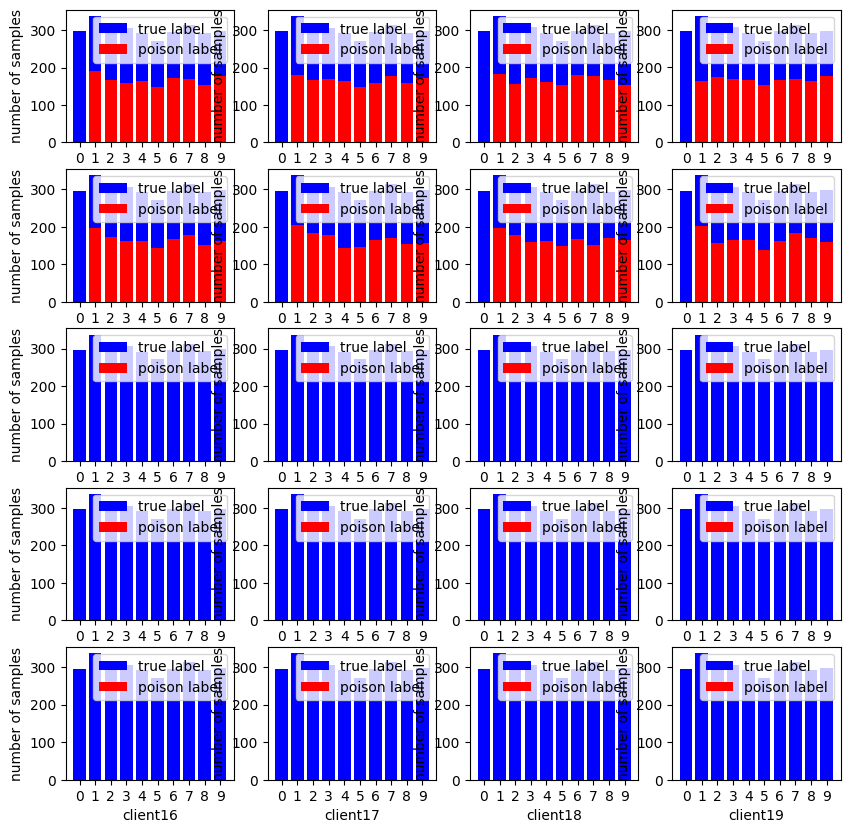

In [48]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import random
import os
import copy
from tqdm import tqdm
from matplotlib import pyplot as plt



# ================================== 参数设置 ====================================   
# 选择数据集
dataset_name = 'MNIST'
# dataset_name = 'FashionMNIST'
# dataset_name = 'CIFAR10'

# attack_method = 'SignFlipping'
# attack_method = 'LabelFlipping'
# attack_method = 'Noise-(0,1)'

# attack_method = 'IPM-0.1'
# attack_method = 'IPM-100'
attack_method = 'Backdoor'
# attack_method = 'NoAttack'
# attack_method = 'ALIE'
# attack_method = 'MinMax'

# 攻击类型限制范围
attack_methods = ['LabelFlipping', 'SignFlipping', 'Noise-(0,1)', 'ALIE', 'MinMax', 'IPM-0.1', 'IPM-100', 'Backdoor', 'NoAttack']
assert attack_method in attack_methods, "attack_method should be one of {}".format(attack_methods)

if attack_method == 'Backdoor':
    backdoor = True
else:
    backdoor = False
print("backdoor attack: ", backdoor)


defense_method = 'FedAvg'
# defense_method = 'FLUD'


# poisioned client portion
poisoned_client_portion = 0.4

# poisioned data portion
poison_data_portion = 0.5
print("poisoned data portion in each client: ", poison_data_portion)

# target label
target_label = 0
print("target label: ", target_label)

# 设置数据集的超参数
num_clients = 20
num_classes = 10

gpu_id = 3

iid = True

# iid = False
alpha = 0.1

given_size = 4096

# 被comprised的客户端的index
comprised_client_idx = range(num_clients)
print("comprised_client_idx: ", comprised_client_idx)




# ===============================================================

# 生成保存目录的函数
def get_processed_data_dir(dataset_name, iid, alpha, num_clients, backdoor, poisoned_client_portion, poison_data_portion):
    if iid == True:
        data_dir = '~/processed_data/{}_iid-{}_numclients-{}_backdoor-{}_poisonedclientsportion-{}_poisoneddataportion-{}/'.format(dataset_name, iid, num_clients, backdoor, poisoned_client_portion, poison_data_portion)
    else:
        data_dir = '~/processed_data/{}_iid-{}_alpha-{}_numclients-{}_backdoor-{}_poisonedclientsportion-{}_poisoneddataportion-{}/'.format(dataset_name, iid, alpha, num_clients, backdoor, poisoned_client_portion, poison_data_portion)
    return data_dir

# 读取数据所在的目录
read_dir = get_processed_data_dir(dataset_name, iid, alpha, num_clients, backdoor, poisoned_client_portion, poison_data_portion)
print("read_dir: ", read_dir)

import os
# 扩展波浪号到用户主目录
read_dir = os.path.expanduser(read_dir)
# 检查目录是否存在, 不存在则发出警告
if not os.path.exists(read_dir):
    print("Warning: the directory does not exist!")

# 读取每个客户端的数据
def load_multiple_client_training_data(num_clients, read_dir):
    clients_images_list = [[] for _ in range(num_clients)]
    clients_labels_list = [[] for _ in range(num_clients)]
    clients_modified_labels_list = [[] for _ in range(num_clients)]
    for i in range(num_clients):
        data = np.load(read_dir + 'client{}_data.npz'.format(i))
        clients_images_list[i] = data['images']
        clients_labels_list[i] = data['labels']
        clients_modified_labels_list[i] = data['modified_labels']
    test_data = np.load(read_dir + 'test_acc_data.npz')
    test_images = test_data['images']
    test_labels = test_data['labels']

    test_asr_data = np.load(read_dir + 'test_asr_data.npz')
    test_asr_images = test_asr_data['images']
    test_asr_labels = test_asr_data['labels']

    return clients_images_list, clients_labels_list, clients_modified_labels_list, test_images, test_labels, test_asr_images, test_asr_labels


# clients_labels_list[i][j] 表示第i个客户端的第j个样本(不是按类别的)的标签
"""
np.where(arr > 5) 返回一个元组，其中每个元素是一个数组，表示满足条件的元素的索引。对于一维数组，元组中只有一个元素。
np.where(arr > 5)[0] 直接返回元组中的第一个元素，即索引数组本身。
"""
# 统计每个客户端的每个样本的标签数量, 并画图
def get_statistic_of_dataset(clients_labels_list, clients_modified_labels_list, num_clients, num_classes):
    # 每个客户端每个类别的idx
    clients_label_numbers_2D_list = [[0 for _ in range(num_classes)] for _ in range(num_clients)]
    
    # 每个客户端每个类别被投毒的数量
    clients_poison_label_numbers_2D_list = [[0 for _ in range(num_classes)] for _ in range(num_clients)]
    

    for i in range(num_clients):
        for j in range(num_classes):
            # 客户端i中真实类别为j的 样本index
            index_i_true_j = np.where(clients_labels_list[i] == j)[0]
            clients_label_numbers_2D_list[i][j] = len(index_i_true_j)
            # 进一步检查是否被投毒, index_i_true_j中的 clients_modified_labels_list[i][index_i_true_j] != j 的index记作index_i_poison_j
            index_i_poison_j = np.where(clients_modified_labels_list[i][index_i_true_j] != j)[0]
            clients_poison_label_numbers_2D_list[i][j] = len(index_i_poison_j)
            
    print("clients_label_numbers_2D_list: ", clients_label_numbers_2D_list)
    print("clients_poison_label_numbers_2D_list: ", clients_poison_label_numbers_2D_list)
    # 画图, 在同一张图上同时画出每个客户端每个样本的数量的散点图, 每个客户端每个样本的数量的散点图
    plt.figure(figsize=(10, 10))
    for i in range(num_clients):
        plt.subplot(5, 4, i+1)
        plt.xticks(range(num_classes))
        plt.bar(range(num_classes), clients_label_numbers_2D_list[i], color='b', label='true label')
        plt.bar(range(num_classes), clients_poison_label_numbers_2D_list[i], color='r', label='poison label')
        plt.xlabel('client{}'.format(i))
        plt.ylabel('number of samples')
        plt.legend()
    plt.show()

# 加载数据, 并统计每个客户端的每个样本的标签数量及恶意标签数量
clients_images_numpuy_list, clients_labels_list, clients_modified_labels_list, test_acc_images, test_acc_labels, test_asr_images, test_asr_labels = load_multiple_client_training_data(num_clients, read_dir)
get_statistic_of_dataset(clients_labels_list, clients_modified_labels_list, num_clients, num_classes)



In [49]:
# # 定义compriomised_clients的攻击手段 attack_methods = ['LabelFlipping', 'SignFlipping', 'Noise', 'ALIE', 'MinMax', 'IPM', 'Backdoor']
# def train_and_get_local_update_of_attack_LabelFlipping(client_index, local_model, local_optimizer, train_loader, local_epochs):
    
#     for epoch in range(local_epochs):
#         local_model.train()
#         for batch_idx, (data, target) in enumerate(train_loader):
#             # 修改标签为 9-label, 然后训练
#             target = 9 - target
#             data, target = data.to(device), target.to(device)
#             output = local_model(data)
#             loss = F.cross_entropy(output, target)
#             local_optimizer.zero_grad()
#             loss.backward()
#             local_optimizer.step()
    
            

# # 定义单个客户端的训练函数
# def train_and_get_local_update_of_single_client(client_index, local_model, local_optimizer, train_loader, local_epochs):
#     # 记录本轮初始的模型参数
#     intial_model = copy.deepcopy(local_model.state_dict())
    
#     # 定义损失函数
#     criterion = nn.CrossEntropyLoss()
#     # 记录训练loss
#     train_loss = 0.0

#     # 每个客户端的训练数据
#     for epoch in range(local_epochs):
#         local_model.train()
#         for images, labels in train_loader:
#             images, labels = images.to(device), labels.to(device)
#             # 前向传播
#             outputs = local_model(images)
#             loss = criterion(outputs, labels)
#             # 反向传播
#             local_optimizer.zero_grad()
#             loss.backward()
#             local_optimizer.step()
#             train_loss += loss.item()
#     # 测试本地模型的ASR
#     # local_model.eval()
#     # asr = test_asr(local_model, test_loader_poison_test_10percent)
#     # print('Client{} local model, ASR: {:.4f}'.format(client_index, asr))

    
#     # loss
#     train_loss /= len(train_loader)
#     print('Client{} local model, Epoch: {}, Loss: {:.4f}'.format(client_index, epoch, train_loss))
#     # 计算本轮训练后的模型参数与初始模型参数的差值
#     local_model_update = {k: local_model.state_dict()[k] - intial_model[k] for k in intial_model}
#     return local_model_update, train_loss


In [50]:



class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(planes, track_running_stats=False)
        self.conv2 = nn.Conv2d(
            planes, planes, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes, track_running_stats=False)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_planes,
                    self.expansion * planes,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(self.expansion * planes, track_running_stats=False),
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes, track_running_stats=False)
        self.conv2 = nn.Conv2d(
            planes, planes, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes, track_running_stats=False)
        self.conv3 = nn.Conv2d(
            planes, self.expansion * planes, kernel_size=1, bias=False
        )
        self.bn3 = nn.BatchNorm2d(self.expansion * planes, track_running_stats=False)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_planes,
                    self.expansion * planes,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(self.expansion * planes, track_running_stats=False),
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64, track_running_stats=False)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet10():
    return ResNet(BasicBlock, [1, 1, 1, 1])

# 用ResNet10模型进行测试
# model = ResNet10()
# print(model)



In [51]:
def set_GPU(gpu_id):
    if torch.cuda.is_available():
        print(f"Number of GPUs available: {torch.cuda.device_count()}")
        if gpu_id < torch.cuda.device_count():
            print(f"Using GPU: {gpu_id}")
            device = torch.device("cuda:{}".format(gpu_id))
        else:
            print(f"GPU id {gpu_id} is not available, using GPU: 0")
            device = torch.device("cuda:0")
    else:
        print("No GPU available")
        device = torch.device("cpu")
    return device


# 定义训练模型, 为逻辑回归模型
# 可训练的参数数量: 7840 = 28*28*10 + 10
class LogisticRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
    def forward(self, x):
        x = x.view(x.size(0), -1)
        out = self.linear(x)
        return out
    
# 定义MLP, 28*28-128-256-10
# 可训练的参数数量: 137074 = 28*28*128 + 128 + 128*256 + 256 + 256*10 + 10
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, output_dim)
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        out = self.fc3(x)
        return out


# 用来训练FashionMNIST数据集的CNN模型
# 用来训练FashionMNIST数据集的CNN模型
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            # nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            # nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.drop = nn.Dropout2d(0.25)
        self.fc1 = nn.Linear(in_features=64 * 6 * 6, out_features=600)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.drop(out)
        out = self.fc1(out)
        out = torch.relu(out)
        out = self.fc2(out)
        out = torch.relu(out)
        out = self.fc3(out)

        return out

# 这是一个GPT生成的简单的CNN模型
# class FashionCNN(nn.Module):
#     def __init__(self):
#         super(FashionCNN, self).__init__()
#         self.layer1 = nn.Sequential(
#             nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2)
#         )
#         self.layer2 = nn.Sequential(
#             nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2)
#         )
#         self.drop_out = nn.Dropout()
#         self.fc1 = nn.Linear(7 * 7 * 64, 1000)
#         self.fc2 = nn.Linear(1000, 10)
#     def forward(self, x):
#         out = self.layer1(x)
#         out = self.layer2(out)
#         out = out.reshape(out.size(0), -1)
#         out = self.drop_out(out)
#         out = torch.relu(self.fc1(out))
#         out = self.fc2(out)
#         return out

# 建立dataset_name: MNIST, FashionMNIST, CIFAR10和模型的映射
dataset_name_to_model_map = {
    'MNIST': MLP(28*28, 128, 256, 10),
    'FashionMNIST': FashionCNN(),
    # 'FashionMNIST': MLP(28*28, 128, 256, 10),
    'CIFAR10': ResNet10()
}


# 初始化全局模型和局部模型
# input_dim = 28 * 28
# output_dim = 10

device = set_GPU(gpu_id)

# 根据dataset_name 对模型进行初始化
global_model = dataset_name_to_model_map[dataset_name]
local_models = [copy.deepcopy(global_model) for _ in range(num_clients)]
# 模型转为device
global_model.to(device)
local_models = [local_model.to(device) for local_model in local_models]

# 打印参数数量的函数
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)



# 并打印出global_model的结构
print('global_model: ', global_model)
# 打印可训练的参数数量
print("Number of trainable parameters: ", count_parameters(global_model))






Number of GPUs available: 4
Using GPU: 3
global_model:  MLP(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)
Number of trainable parameters:  136074


In [52]:
# 定义单个客户端的训练函数
def train_and_get_local_update_of_single_client(client_index, local_model, local_optimizer, train_loader, local_epochs):
    # 记录本轮初始的模型参数
    intial_model = copy.deepcopy(local_model.state_dict())
    
    # 定义损失函数
    criterion = nn.CrossEntropyLoss()
    # 记录训练loss
    train_loss = 0.0

    # 每个客户端的训练数据
    for epoch in range(local_epochs):
        local_model.train()
        for images, labels in train_loader:
            # 检查images是否被归一化
            # print(images.max(), images.min(), images.mean(), images.std())
            
            images, labels = images.to(device), labels.to(device)
            # 前向传播
            outputs = local_model(images)
            loss = criterion(outputs, labels)
            # 反向传播
            local_optimizer.zero_grad()
            loss.backward()
            # 裁剪梯度
            torch.nn.utils.clip_grad_norm_(local_model.parameters(), 1)
            local_optimizer.step()
            train_loss += loss.item()
            
    # loss
    train_loss /= len(train_loader)
    print('Client{} local model, Epoch: {}, Loss: {:.4f}'.format(client_index, epoch, train_loss))
    # 计算本轮训练后的模型参数与初始模型参数的差值
    local_model_update = {k: local_model.state_dict()[k] - intial_model[k] for k in intial_model}
    # print("local_model_update: ", local_model_update)
    return local_model_update, train_loss

# 定义compriomised_clients的攻击手段 attack_methods = ['LabelFlipping', 'SignFlipping', 'Noise', 'ALIE', 'MinMax', 'IPM', 'Backdoor']
def train_and_get_local_update_of_attack_LabelFlipping(client_index, local_model, local_optimizer, train_loader, local_epochs):
    # 记录本轮初始的模型参数
    intial_model = copy.deepcopy(local_model.state_dict())
    
    # 定义损失函数
    criterion = nn.CrossEntropyLoss()
    # 记录训练loss
    train_loss = 0.0
    for epoch in range(local_epochs):
        local_model.train()
        for images, labels in train_loader:
            # 修改标签为 9-label, 然后训练
            labels = 9 - labels
            images, labels = images.to(device), labels.to(device)
            # 前向传播
            outputs = local_model(images)
            loss = criterion(outputs, labels)
            # 反向传播
            local_optimizer.zero_grad()
            loss.backward()
            # 裁剪梯度
            torch.nn.utils.clip_grad_norm_(local_model.parameters(), 1)
            local_optimizer.step()
            train_loss += loss.item()
    # loss
    train_loss /= len(train_loader)
    print('Client{} local model, Epoch: {}, Loss: {:.4f}'.format(client_index, epoch, train_loss))
    # 计算本轮训练后的模型参数与初始模型参数的差值
    local_model_update = {k: local_model.state_dict()[k] - intial_model[k] for k in intial_model}
    return local_model_update, train_loss
        
# 定义SignFlipping的攻击函数
def train_and_get_local_update_of_attack_SignFlipping(client_index, local_model, local_optimizer, train_loader, local_epochs):
    # 记录本轮初始的模型参数
    intial_model = copy.deepcopy(local_model.state_dict())
    
    # 定义损失函数
    criterion = nn.CrossEntropyLoss()

    # 记录训练loss
    train_loss = 0.0
    for epoch in range(local_epochs):
        local_model.train()
        # 计算完梯度都会取反
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = local_model(images)
            loss = criterion(outputs, labels)
            local_optimizer.zero_grad()
            loss.backward()
            # 裁剪梯度
            torch.nn.utils.clip_grad_norm_(local_model.parameters(), 1)

            train_loss += loss.item()
            for param in local_model.parameters():
                param.grad.data = -param.grad.data
            local_optimizer.step()
            
    # loss, 为什么是nan? 因为计算的梯度是负数, 但是计算的loss是正数, 所以loss会是nan
    train_loss /= len(train_loader)
    print('Client{} local model, Epoch: {}, Loss: {:.4f}'.format(client_index, epoch, train_loss))
    # 计算本轮训练后的模型参数与初始模型参数的差值
    local_model_update = {k: local_model.state_dict()[k] - intial_model[k] for k in intial_model}
    return local_model_update, train_loss

# 定义Noise的攻击函数
def train_and_get_local_update_of_attack_Noise(client_index, local_model):
    noise_mean=0
    noise_std=1
    # 模型更新为和模型参数同形状的正态分布
    local_model_update = {k: torch.normal(mean=noise_mean, std=noise_std, size=local_model.state_dict()[k].shape).to(device) for k in local_model.state_dict()}
    train_loss = 0
    return local_model_update, train_loss

# 定义IPM的攻击函数
def train_and_get_local_update_of_attack_IPM(benign_update_mean, scale):
    # 相反方向的scale倍缩放
    local_model_update = {k: -scale * benign_update_mean[k] for k in benign_update_mean}
    train_loss = 0
    return local_model_update, train_loss

# 定义ALIE的攻击函数
def train_and_get_local_update_of_attack_ALIE(num_clients, num_byzantine, benign_update_mean, benign_update_std):
    #  计算z_max
    s = torch.floor_divide(num_clients, 2) + 1 - num_byzantine
    cdf_value = (num_clients - num_byzantine - s) / (num_clients - num_byzantine)
    dist = torch.distributions.normal.Normal(torch.tensor(0.0), torch.tensor(1.0))
    z_max = dist.icdf(cdf_value)
    # update = mean + std * z_max
    # 对每个entry进行缩放
    local_model_update = {k: benign_update_mean[k] + benign_update_std[k] * z_max for k in benign_update_mean}
    train_loss = 0
    return local_model_update, train_loss


# 定义一个函数, 计算两个local_model_update的L2距离
def l2_distance_of_2_updates(model_update1, model_update2):
    distance = 0
    for k in model_update1:
        distance += torch.norm(model_update1[k] - model_update2[k], p=2) ** 2
    return torch.sqrt(distance)


def minmax_attack_by_binary_search(benign_update_mean, benign_update_std, benign_updates, benign_clients_index):
    # 所有良性梯度的mean, 标准差, 良性梯度的之间距离的最大值
    all_distances_of_benign_updates = torch.stack([l2_distance_of_2_updates(benign_updates[i], benign_updates[j]) for i in benign_clients_index for j in benign_clients_index])
    threshold = all_distances_of_benign_updates.max()

    low = 0
    high = 5
    while abs(high - low) > 0.01:
        mid = (low + high) / 2
        # mal_update = torch.stack([mean_grads - mid * deviation])
        malicious_update = {k: benign_update_mean[k] - mid * benign_update_std[k] for k in benign_update_mean}
        # loss = torch.cdist(mal_update, benign_updates, p=2).max()
        loss = torch.stack([l2_distance_of_2_updates(malicious_update, benign_updates[i]) for i in benign_clients_index]).max()
        if loss < threshold:
            low = mid
        else:
            high = mid
    train_loss = 0
    return malicious_update, train_loss






In [53]:

# 考虑所有攻击方式

global_learning_rate = 1

# 定义超参数
batch_size = 128
local_learning_rate = 0.1
local_momentum = 0.9 # 动量
local_weight_decay = 0
# local_weight_decay = 5e-4 # L2正则化系数

# global_rounds是全局迭代次数
global_rounds = 50
# local_epochs是每个客户端的本地训练次数
local_epochs = 10

# 每round选择的客户端比例
selected_clients_portion = 1
selected_clients_index = random.sample(range(num_clients), int(num_clients * selected_clients_portion))
# 排序index 
selected_clients_index.sort()

# 加载数据集
print("clients_images_list: ", len(clients_images_numpuy_list))
print("clients_images_list[0]: ", clients_images_numpuy_list[0].shape, type(clients_images_numpuy_list[0]))
print("clients_images_list[0][0]", clients_images_numpuy_list[0][0].shape, type(clients_images_numpuy_list[0][0]))

# 训练数据集转为可训练的格式
for i in range(num_clients):
    clients_images_numpuy_list[i] = torch.from_numpy(clients_images_numpuy_list[i]).float()
    # labels是整数
    clients_labels_list[i] = torch.from_numpy(clients_labels_list[i]).long()
    clients_modified_labels_list[i] = torch.from_numpy(clients_modified_labels_list[i]).long()


# 转为dataloader
# 标签会影响测试集的准确率
train_loaders = [DataLoader(torch.utils.data.TensorDataset(clients_images_numpuy_list[i], clients_modified_labels_list[i]), batch_size=batch_size, shuffle=True) for i in range(num_clients)]
# train_loaders = [DataLoader(torch.utils.data.TensorDataset(clients_images_numpuy_list[i], clients_labels_list[i]), batch_size=batch_size, shuffle=True) for i in range(num_clients)]

# 测试集转为可训练的格式
test_acc_images = torch.from_numpy(test_acc_images).float()
test_acc_labels = torch.from_numpy(test_acc_labels).long()
# 转为dataloader
test_acc_dataset = torch.utils.data.TensorDataset(test_acc_images, test_acc_labels)
test_acc_loader = torch.utils.data.DataLoader(dataset=test_acc_dataset, batch_size=len(test_acc_images), shuffle=False)

# test_asr_images转为可训练的格式
test_asr_images = torch.from_numpy(test_asr_images).float()
test_asr_labels = torch.from_numpy(test_asr_labels).long()
# 转为dataloader
test_asr_dataset = torch.utils.data.TensorDataset(test_asr_images, test_asr_labels)
test_asr_loader = torch.utils.data.DataLoader(dataset=test_asr_dataset, batch_size=len(test_asr_images), shuffle=False)

target_label = 0


# 打印每个客户端的训练集数量
for i in range(num_clients):
    print("Client{} dataset size: {}".format(i, len(clients_images_numpuy_list[i])))
print("Test dataset size: ", len(test_acc_images))
print("Test ASR dataset size: ", len(test_asr_images))

# 定义优化器
global_optimizer = optim.SGD(global_model.parameters(), lr = global_learning_rate)
# local_optimizers = [optim.SGD(local_models[i].parameters(), lr = local_learning_rate) for i in range(num_clients)]
local_optimizers = [optim.SGD(local_models[i].parameters(), lr= local_learning_rate, momentum=local_momentum, weight_decay=local_weight_decay) for i in range(num_clients)]


# 定义函数, 获取并返回每个客户端的训练集数量
def get_client_dataset_numbers(clients_images_numpuy_list, num_clients):
    number_of_samples_each_client_list = [0] * num_clients
    for i in range(num_clients):
        number_of_samples_each_client_list[i] = len(clients_images_numpuy_list[i])
    return number_of_samples_each_client_list


# 定义测试函数
def test_acc(global_model, test_loader):
    global_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = global_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# 定义投毒成功率测试函数
def test_asr(model, test_loader_asr):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader_asr:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            # print('predicted: ', predicted)
            # print('labels: ', labels)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

def aggregate_local_model_updates_by_weight(local_model_updates, weights_of_select_clients):
    print('本轮被聚合的客户端数量: ', len(local_model_updates))
    assert len(local_model_updates) == len(weights_of_select_clients)
    global_model_update = {k: torch.zeros_like(local_model_updates[0][k]) for k in local_model_updates[0]}
    for k in global_model_update:
        for i in range(len(local_model_updates)):
            global_model_update[k] += local_model_updates[i][k] * weights_of_select_clients[i]
    return global_model_update

def aggregate_local_updates_by_avg(local_model_updates):
    global_model_update = {k: torch.zeros_like(local_model_updates[0][k]) for k in local_model_updates[0]}
    for k in global_model_update:
        for i in range(len(local_model_updates)):
            global_model_update[k] += local_model_updates[i][k]
        global_model_update[k] /= len(local_model_updates)
    return global_model_update


def get_save_results_dir(dataset_name, iid, alpha, num_clients, attack_method, defense_method):
    if iid == True:
        results_dir = '~/results/{}_iid-{}_numclients-{}_attack-{}_defense-{}_'.format(dataset_name, iid, num_clients, attack_method, defense_method)
    else:
        results_dir = '~/results/{}_iid-{}_alpha-{}_numclients-{}_attack-{}_defense-{}_'.format(dataset_name, iid, alpha, num_clients, attack_method, defense_method)
    # 以及一个4bytes随机的字符串, 
    # 加上年月日时分秒
    import datetime
    results_dir += datetime.datetime.now().strftime('%Y%m%d%H%M%S')
    import uuid
    results_dir += str(uuid.uuid4())[:4] + '/'
    return results_dir





clients_images_list:  20
clients_images_list[0]:  (3006, 1, 28, 28) <class 'numpy.ndarray'>
clients_images_list[0][0] (1, 28, 28) <class 'numpy.ndarray'>
Client0 dataset size: 3006
Client1 dataset size: 3005
Client2 dataset size: 3003
Client3 dataset size: 3002
Client4 dataset size: 3002
Client5 dataset size: 3001
Client6 dataset size: 3001
Client7 dataset size: 3001
Client8 dataset size: 3001
Client9 dataset size: 3000
Client10 dataset size: 3000
Client11 dataset size: 2998
Client12 dataset size: 2998
Client13 dataset size: 2998
Client14 dataset size: 2998
Client15 dataset size: 2998
Client16 dataset size: 2998
Client17 dataset size: 2998
Client18 dataset size: 2996
Client19 dataset size: 2996
Test dataset size:  10000
Test ASR dataset size:  9020


In [54]:


# 用数据集, iid, 攻击类型, 年月日时分秒, 作为存储config.json和results.json的目录
save_reslult_dir = get_save_results_dir(dataset_name, iid, alpha, num_clients, attack_method, defense_method)
save_reslult_dir = os.path.expanduser(save_reslult_dir)
if not os.path.exists(save_reslult_dir):
    os.makedirs(save_reslult_dir)
print("save_reslult_dir: ", save_reslult_dir)

# 存储config.json
config = {
    "defense_method": defense_method,
    "batch_size": batch_size,
    "attack_method": attack_method,
    "local_epochs": local_epochs,
    "local_learning_rate": local_learning_rate,
    "num_clients": num_clients,
    "num_classess": num_classes,
    "join_ratio": selected_clients_portion,
    "dataset": read_dir,
    "global_rounds": global_rounds,
    "given_size": 4096,
}
# 存储config.json
import json
with open(save_reslult_dir + 'config.json', 'w') as f:
    json.dump(config, f, indent=4)

# 存储结果的result.json的路径
results_json_path = save_reslult_dir + 'result.json'


# 获取每个客户端的训练集数量, 并转为权重
number_of_samples_each_client_list = get_client_dataset_numbers(clients_images_numpuy_list, num_clients)
weights_of_select_clients = [number_of_samples_each_client_list[i] / sum(number_of_samples_each_client_list) for i in selected_clients_index]

# 使用滑动窗口对一维向量进行采样, 返回max(abs())
def max_abs_of_sliding_window(vector, window_size):
    # 先转为绝对值
    vector = torch.abs(vector)
    # 然后用max_pool1d, ceil = True, 保证最后一个窗口不会被舍弃
    max_pool = nn.MaxPool1d(window_size, stride=window_size, ceil_mode=True)
    vector = vector.unsqueeze(0)
    vector = max_pool(vector)
    return vector.squeeze()

# 传入一个模型更新, 将它转为一个向量, 并返回这个向量
def update_update_convert_to_vector(model_update):
    # print([k for k in model_update])
    return torch.cat([model_update[k].flatten() for k in model_update])

# 计算向量之间的两两欧氏距离
def compute_euclid_dis(vectors_list):
    num = len(vectors_list)
    dis_max = np.zeros((num, num))
    for i in range(num):
        for j in range(i + 1, num):
            dis_max[i, j] =torch.sqrt(torch.sum((vectors_list[i] - vectors_list[j]) ** 2))
            dis_max[j, i] = dis_max[i, j]
    return dis_max

# 距离矩阵转为投票向量
def votes_by_dismatrix(dis_matrix):
    # 获取每行前10个最小距离值的索引
    top_indices = np.argsort(dis_matrix, axis=1)[:, :10]
    # 创建一个全零的矩阵，然后将每行的[10个最小距离值的索引]位置标为1
    result_matrix = np.zeros_like(dis_matrix)
    rows, cols = np.indices(top_indices.shape)
    result_matrix[rows, top_indices] = 1
    column_sums = np.sum(result_matrix, axis=0)
    return column_sums

# 训练
for round in range(global_rounds):
    print('Global round: {}=========================='.format(round))
    # 下发全局模型
    for i in range(num_clients):
        local_models[i].load_state_dict(global_model.state_dict())

    
    # 恶意客户端的数量 和 index
    num_byzantine = int(num_clients * poisoned_client_portion)
    malicious_client_index = list(range(num_byzantine))

    # 良性客户端的index
    benign_clients_index = list(range(num_byzantine, num_clients))

    print('malicious_clients_index: ', malicious_client_index)  
    print('benign_clients_index: ', benign_clients_index)

    # 记录每个客户端的模型更新 和 损失
    malicious_updates, benign_updates, clients_losses = {}, {}, {}

    # 获取所有良性客户端的更新
    for i in benign_clients_index:
        benign_update, loss = train_and_get_local_update_of_single_client(i, local_models[i], local_optimizers[i], train_loaders[i], local_epochs)
        benign_updates[i] = benign_update
        clients_losses[i] = loss
        # print('update of client{}: '.format(i), benign_updates[i])  
    
    # 计算每个entry的均值
    benign_update_mean = {k: torch.mean(torch.stack([benign_updates[i][k] for i in benign_clients_index]), dim=0) for k in global_model.state_dict()}
    # 计算每个entry的标准差
    benign_update_std = {k: torch.std(torch.stack([benign_updates[i][k] for i in benign_clients_index]), dim=0) for k in global_model.state_dict()}
    
    # print('benign_update_mean: ', benign_update_mean)
    # print('benign_update_std: ', benign_update_std)
    

    print('attack method: ', attack_method) 
    # 获取所有恶意客户端的更新
    if attack_method == 'LabelFlipping':
        for i in malicious_client_index:
            malicious_update, loss = train_and_get_local_update_of_attack_LabelFlipping(i, local_models[i], local_optimizers[i], train_loaders[i], local_epochs)
            malicious_updates[i] = malicious_update
            clients_losses[i] = loss
    elif attack_method == 'Backdoor' or attack_method == 'NoAttack':
        for i in malicious_client_index:
            malicious_update, loss = train_and_get_local_update_of_single_client(i, local_models[i], local_optimizers[i], train_loaders[i], local_epochs)
            malicious_updates[i] = malicious_update
            clients_losses[i] = loss
    elif attack_method == 'SignFlipping':
        for i in malicious_client_index:
            malicious_update, loss = train_and_get_local_update_of_attack_SignFlipping(i, local_models[i], local_optimizers[i], train_loaders[i], local_epochs)
            malicious_updates[i] = malicious_update
            clients_losses[i] = loss
    elif attack_method == 'Noise-(0,1)':
        for i in malicious_client_index:
            malicious_update, loss = train_and_get_local_update_of_attack_Noise(i, local_models[i])
            malicious_updates[i] = malicious_update
            clients_losses[i] = loss
    elif attack_method == 'IPM-0.1':
        ipm_update, loss = train_and_get_local_update_of_attack_IPM(benign_update_mean, 0.1)
        # malicious updates都是一样的
        malicious_updates = {i: ipm_update for i in malicious_client_index}
        for i in malicious_client_index:
            clients_losses[i] = loss
    elif attack_method == 'IPM-100':
        ipm_update, loss = train_and_get_local_update_of_attack_IPM(benign_update_mean, 100)
        # malicious updates都是一样的
        malicious_updates = {i: ipm_update for i in malicious_client_index}
        for i in malicious_client_index:
            clients_losses[i] = loss
    elif attack_method == 'MinMax':
        minmax_update, loss = minmax_attack_by_binary_search(benign_update_mean, benign_update_std, benign_updates, benign_clients_index)
        # malicious updates都是一样的
        malicious_updates = {i: minmax_update for i in malicious_client_index}
        for i in malicious_client_index:
            clients_losses[i] = loss
    elif attack_method == 'ALIE':
        alie_update, loss = train_and_get_local_update_of_attack_ALIE(num_clients, num_byzantine, benign_update_mean, benign_update_std)
        # malicious updates都是一样的
        print('ALIE update: ', alie_update)
        malicious_updates = {i: alie_update for i in malicious_client_index}
        for i in malicious_client_index:
            clients_losses[i] = loss
    else:
        raise ValueError('Invalid attack method')



    print('defense_method: ', defense_method)
    # 这里用于计算全局模型的更新
    if defense_method == 'FedAvg':
        # 用于聚合的所有客户端的index
        aggregated_clients_index = malicious_client_index + benign_clients_index
        aggregated_clients_weights = [weights_of_select_clients[i] for i in aggregated_clients_index]

        # 对所有客户端的更新进行加权平均
        global_model_update = aggregate_local_model_updates_by_weight([malicious_updates[i] for i in malicious_client_index] + [benign_updates[i] for i in benign_clients_index], weights_of_select_clients)
    elif defense_method == 'FLUD':
        # 防御方法: 计算所有更新的拍平的向量, 对这个向量使用滑动窗口采样中的max(abs(model update)), 记作 model digest
        window_size = given_size
        model_digest = {}
        for i in range(num_clients):
            if i in malicious_client_index:
                model_digest[i] = max_abs_of_sliding_window(update_update_convert_to_vector(malicious_updates[i]), window_size)
            else:
                model_digest[i] = max_abs_of_sliding_window(update_update_convert_to_vector(benign_updates[i]), window_size)
        # 取出所有digest, 放到一个list中
        all_digests_list = [model_digest[i] for i in range(num_clients)]
        # 计算欧氏距离
        distance_matrix = compute_euclid_dis(all_digests_list)
        # print('distance_matrix: ', distance_matrix)
        # 投票
        votes = votes_by_dismatrix(distance_matrix)
        # 对votes中小于10的元素, 用0代替
        votes[votes < 10] = 0
        # 获取那些非0 的元素的index, 并转为list
        non_zero_clients_index = list(np.nonzero(votes)[0])

        # 被聚合的客户端的index
        aggregated_clients_index = non_zero_clients_index
        # 他们的权重
        aggregated_clients_weights = [weights_of_select_clients[i] for i in aggregated_clients_index]


        # aggregated_clients_index 中恶意客户端的index
        aggregated_malicious_client_index = [i for i in aggregated_clients_index if i in malicious_client_index]
        # aggregated_clients_index 中良性客户端的index
        aggregated_benign_clients_index = [i for i in aggregated_clients_index if i in benign_clients_index]

        # 对non zero客户端的更新进行加权平均, 其中包括了恶意客户端和良性客户端
        global_model_update = aggregate_local_model_updates_by_weight([malicious_updates[i] for i in aggregated_malicious_client_index] + [benign_updates[i] for i in aggregated_benign_clients_index], aggregated_clients_weights)
        
    # 被聚合的客户端的index
    print('aggregated_clients_index: ', aggregated_clients_index)
    # 打印权重
    print('aggregated_clients_weights: ', aggregated_clients_weights)
    

    # 计算全局模型
    # global_model_update = aggregate_local_model_updates_by_weight([malicious_updates[i] for i in malicious_client_index] + [benign_updates[i] for i in benign_clients_index] , weights_of_select_clients)
    # global_model_update = aggregate_local_updates_by_avg(local_model_updates)

    # print('global_model_update: ', global_model_update) 

    # 用 global optimizer 更新全局模型
    for name, param in global_model.named_parameters():
        param.data += global_model_update[name]
    
    # 测试
    accuracy = test_acc(global_model, test_acc_loader)
    asr = test_asr(global_model, test_asr_loader)
    print('Global round: {}, Accuracy: {:.4f}, ASR: {:.4f}'.format(round, accuracy, asr))

    # 对字典client_losses进行排序
    clients_losses = dict(sorted(clients_losses.items(), key=lambda x: x[0]))

    # 存储结果
    result = {
        "training_iteration": round,
        "acc_top_1": accuracy,
        "test_asr": asr,
        "train_loss": clients_losses
    }
    with open(results_json_path, 'a') as f:
        json.dump(result, f)
        f.write('\n')

save_reslult_dir:  /scratch/wenjie/results/MNIST_iid-True_numclients-20_attack-Backdoor_defense-FedAvg_202405241225240d57/
Global round: 0==========================
malicious_clients_index:  [0, 1, 2, 3, 4, 5, 6, 7]
benign_clients_index:  [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Client8 local model, Epoch: 9, Loss: 2.6926
Client9 local model, Epoch: 9, Loss: 2.8687
Client10 local model, Epoch: 9, Loss: 2.5247
Client11 local model, Epoch: 9, Loss: 2.6034
Client12 local model, Epoch: 9, Loss: 2.5343
Client13 local model, Epoch: 9, Loss: 2.7037
Client14 local model, Epoch: 9, Loss: 2.8391
Client15 local model, Epoch: 9, Loss: 2.6855
Client16 local model, Epoch: 9, Loss: 2.7819
Client17 local model, Epoch: 9, Loss: 2.5511
Client18 local model, Epoch: 9, Loss: 2.6845
Client19 local model, Epoch: 9, Loss: 2.5104
attack method:  Backdoor
Client0 local model, Epoch: 9, Loss: 2.2491
Client1 local model, Epoch: 9, Loss: 2.1891
Client2 local model, Epoch: 9, Loss: 2.3490
Client3 local model

In [55]:
# 使用滑动窗口对一维向量进行采样, 返回max(abs())
def max_abs_of_sliding_window(vector, window_size):
    # 先转为绝对值
    vector = torch.abs(vector)
    # 然后用max_pool1d, ceil = True, 保证最后一个窗口不会被舍弃
    max_pool = nn.MaxPool1d(window_size, stride=window_size, ceil_mode=True)
    vector = vector.unsqueeze(0)
    vector = max_pool(vector)
    return vector.squeeze()

# 传入一个模型更新, 将它转为一个向量, 并返回这个向量
def update_update_convert_to_vector(model_update):
    # print([k for k in model_update])
    return torch.cat([model_update[k].flatten() for k in model_update])


    

# 用真实的数据测试
test_model = FashionCNN()
test_model.to(device)

# 随机初始化这个模型
for param in test_model.parameters():
    param.data = torch.randn_like(param.data)

# 随机初始化一个model update
def get_a_random_update(test_model):
    test_model_update = {}
    for name, param in test_model.named_parameters():
        test_model_update[name] = torch.randn_like(param.data)
    return test_model_update


# 初始化20个模型更新
test_model_updates = [get_a_random_update(test_model) for _ in range(20)]

# 拍平每个模型更新, 并转为向量, 然后用滑动窗口采样
test_model_digests = [max_abs_of_sliding_window(update_update_convert_to_vector(test_model_update), 4096) for test_model_update in test_model_updates]


# 计算向量之间的两两欧氏距离
def compute_euclid_dis(vectors_list):
    num = len(vectors_list)
    dis_max = np.zeros((num, num))
    for i in range(num):
        for j in range(i + 1, num):
            dis_max[i, j] =torch.sqrt(torch.sum((vectors_list[i] - vectors_list[j]) ** 2))
            dis_max[j, i] = dis_max[i, j]
    return dis_max

# 距离矩阵转为投票向量
def votes_by_dismatrix(dis_matrix):
    # 获取每行前10个最小距离值的索引
    top_indices = np.argsort(dis_matrix, axis=1)[:, :10]
    # 创建一个全零的矩阵，然后将每行的[10个最小距离值的索引]位置标为1
    result_matrix = np.zeros_like(dis_matrix)
    rows, cols = np.indices(top_indices.shape)
    result_matrix[rows, top_indices] = 1
    column_sums = np.sum(result_matrix, axis=0)
    return column_sums

# 计算欧氏距离
distance_matrix = compute_euclid_dis(test_model_digests)
print('distance_matrix: ', distance_matrix)
# 投票
votes = votes_by_dismatrix(distance_matrix)
print('votes: ', votes)

# 对votes中小于10的元素, 用0代替
votes[votes < 10] = 0
# 获取那些非0 的元素的index, 并转为list
non_zero_index = list(np.nonzero(votes)[0])
print('non_zero_index: ', non_zero_index)



    

distance_matrix:  [[0.         7.88279629 8.33061886 7.9268446  8.58481789 8.0285511
  7.86065626 8.25447845 8.11707878 7.93701077 8.34375477 8.48148251
  7.77188349 8.18291092 8.00949574 8.11553478 7.93984985 8.06513023
  8.00411415 8.31973648]
 [7.88279629 0.         8.41043949 8.31537533 8.16246319 8.35215378
  8.07856655 8.56618881 8.30332661 8.16413975 7.98138571 8.34453583
  8.23496819 8.03658009 8.01043701 8.44905758 7.7818656  8.00056267
  8.03431416 8.63281631]
 [8.33061886 8.41043949 0.         8.79685783 8.70140171 8.60919285
  8.73028374 8.80933189 8.89496899 8.23511982 8.65723515 8.96801758
  8.52684307 8.33542252 8.73710823 8.63765621 8.28316021 8.73515606
  8.60381985 8.96966648]
 [7.9268446  8.31537533 8.79685783 0.         8.43524265 8.52832699
  8.02221584 8.90050983 8.45797348 8.01279259 8.29340935 8.54964733
  8.41424084 8.36520004 8.24958611 8.45317936 7.97335386 8.5012722
  8.0773325  8.23027706]
 [8.58481789 8.16246319 8.70140171 8.43524265 0.         8.40279961


round 0和1能够没有很好地检测出后门梯度, 以至于聚合了一些恶意梯度
round 2, 3...都能很好地检测后门梯度, 但模型已经记住了很多后门的知识,以至于还是有25%左右的asr

save_reslult_dir:  /scratch/wenjie/results/FashionMNIST_iid-True_numclients-20_attack-Backdoor_defense-FLUD_20240522173236672a/
Global round: 0==========================
malicious_clients_index:  [0, 1, 2, 3, 4, 5, 6, 7]
benign_clients_index:  [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Client8 local model, Epoch: 9, Loss: 6.6962
Client9 local model, Epoch: 9, Loss: 6.9018
Client10 local model, Epoch: 9, Loss: 7.2941
Client11 local model, Epoch: 9, Loss: 6.7093
Client12 local model, Epoch: 9, Loss: 7.3471
Client13 local model, Epoch: 9, Loss: 7.2012
Client14 local model, Epoch: 9, Loss: 8.0264
Client15 local model, Epoch: 9, Loss: 7.5083
Client16 local model, Epoch: 9, Loss: 6.6590
Client17 local model, Epoch: 9, Loss: 6.6935
Client18 local model, Epoch: 9, Loss: 8.0862
Client19 local model, Epoch: 9, Loss: 6.7152
attack method:  Backdoor
Client0 local model, Epoch: 9, Loss: 4.6193
Client1 local model, Epoch: 9, Loss: 4.8452
Client2 local model, Epoch: 9, Loss: 4.5847
Client3 local model, Epoch: 9, Loss: 4.3990
Client4 local model, Epoch: 9, Loss: 4.6373
Client5 local model, Epoch: 9, Loss: 4.7892
Client6 local model, Epoch: 9, Loss: 4.3232
Client7 local model, Epoch: 9, Loss: 4.4774
defense_method:  FLUD
本轮被聚合的客户端数量:  13
aggregated_clients_index:  [0, 1, 2, 4, 5, 7, 8, 9, 11, 13, 16, 17, 19]
aggregated_clients_weights:  [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
Global round: 0, Accuracy: 0.5899, ASR: 0.8690
Global round: 1==========================
malicious_clients_index:  [0, 1, 2, 3, 4, 5, 6, 7]
benign_clients_index:  [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Client8 local model, Epoch: 9, Loss: 3.8782
Client9 local model, Epoch: 9, Loss: 3.8635
Client10 local model, Epoch: 9, Loss: 4.1641
Client11 local model, Epoch: 9, Loss: 4.2355
Client12 local model, Epoch: 9, Loss: 4.0304
Client13 local model, Epoch: 9, Loss: 3.9476
Client14 local model, Epoch: 9, Loss: 3.9660
Client15 local model, Epoch: 9, Loss: 4.0132
Client16 local model, Epoch: 9, Loss: 3.9185
Client17 local model, Epoch: 9, Loss: 3.9213
Client18 local model, Epoch: 9, Loss: 4.1203
Client19 local model, Epoch: 9, Loss: 4.1743
attack method:  Backdoor
Client0 local model, Epoch: 9, Loss: 2.1282
Client1 local model, Epoch: 9, Loss: 2.1898
Client2 local model, Epoch: 9, Loss: 2.1077
Client3 local model, Epoch: 9, Loss: 2.2451
Client4 local model, Epoch: 9, Loss: 2.2855
Client5 local model, Epoch: 9, Loss: 2.1210
Client6 local model, Epoch: 9, Loss: 2.1234
Client7 local model, Epoch: 9, Loss: 2.2061
defense_method:  FLUD
本轮被聚合的客户端数量:  10
aggregated_clients_index:  [0, 4, 9, 11, 12, 13, 14, 15, 17, 18]
aggregated_clients_weights:  [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
Global round: 1, Accuracy: 0.7805, ASR: 0.6580
Global round: 2==========================
malicious_clients_index:  [0, 1, 2, 3, 4, 5, 6, 7]
benign_clients_index:  [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Client8 local model, Epoch: 9, Loss: 2.5074
Client9 local model, Epoch: 9, Loss: 2.6093
Client10 local model, Epoch: 9, Loss: 2.5452
Client11 local model, Epoch: 9, Loss: 2.6385
Client12 local model, Epoch: 9, Loss: 2.4990
Client13 local model, Epoch: 9, Loss: 2.5047
Client14 local model, Epoch: 9, Loss: 2.5538
Client15 local model, Epoch: 9, Loss: 2.5094
Client16 local model, Epoch: 9, Loss: 2.6878
Client17 local model, Epoch: 9, Loss: 2.6922
Client18 local model, Epoch: 9, Loss: 2.7367
Client19 local model, Epoch: 9, Loss: 2.6026
attack method:  Backdoor
Client0 local model, Epoch: 9, Loss: 1.2425
Client1 local model, Epoch: 9, Loss: 1.4218
Client2 local model, Epoch: 9, Loss: 1.3625
Client3 local model, Epoch: 9, Loss: 1.2719
Client4 local model, Epoch: 9, Loss: 1.4268
Client5 local model, Epoch: 9, Loss: 1.5083
Client6 local model, Epoch: 9, Loss: 1.4409
Client7 local model, Epoch: 9, Loss: 1.4961
defense_method:  FLUD
本轮被聚合的客户端数量:  9
aggregated_clients_index:  [8, 9, 10, 11, 12, 13, 16, 18, 19]
aggregated_clients_weights:  [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
Global round: 2, Accuracy: 0.8396, ASR: 0.4970
Global round: 3==========================
malicious_clients_index:  [0, 1, 2, 3, 4, 5, 6, 7]
benign_clients_index:  [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Client8 local model, Epoch: 9, Loss: 1.9114
Client9 local model, Epoch: 9, Loss: 1.8642
Client10 local model, Epoch: 9, Loss: 1.8353
Client11 local model, Epoch: 9, Loss: 1.9493
Client12 local model, Epoch: 9, Loss: 1.8302
Client13 local model, Epoch: 9, Loss: 1.9098
Client14 local model, Epoch: 9, Loss: 1.9474
Client15 local model, Epoch: 9, Loss: 1.9571
Client16 local model, Epoch: 9, Loss: 1.9081
Client17 local model, Epoch: 9, Loss: 1.9154
Client18 local model, Epoch: 9, Loss: 1.9963
Client19 local model, Epoch: 9, Loss: 1.9768
attack method:  Backdoor
Client0 local model, Epoch: 9, Loss: 1.2340
Client1 local model, Epoch: 9, Loss: 1.1624
Client2 local model, Epoch: 9, Loss: 1.1855
Client3 local model, Epoch: 9, Loss: 1.2990
Client4 local model, Epoch: 9, Loss: 1.4412
Client5 local model, Epoch: 9, Loss: 1.3446
Client6 local model, Epoch: 9, Loss: 1.5788
Client7 local model, Epoch: 9, Loss: 1.1504
defense_method:  FLUD
本轮被聚合的客户端数量:  9
aggregated_clients_index:  [8, 10, 11, 13, 15, 16, 17, 18, 19]
aggregated_clients_weights:  [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
Global round: 3, Accuracy: 0.8529, ASR: 0.4490
Global round: 4==========================
malicious_clients_index:  [0, 1, 2, 3, 4, 5, 6, 7]
benign_clients_index:  [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Client8 local model, Epoch: 9, Loss: 1.4818
Client9 local model, Epoch: 9, Loss: 1.5798
Client10 local model, Epoch: 9, Loss: 1.4132
Client11 local model, Epoch: 9, Loss: 1.6471
Client12 local model, Epoch: 9, Loss: 1.5390
Client13 local model, Epoch: 9, Loss: 1.5625
Client14 local model, Epoch: 9, Loss: 1.6089
Client15 local model, Epoch: 9, Loss: 1.4925
Client16 local model, Epoch: 9, Loss: 1.5723
Client17 local model, Epoch: 9, Loss: 1.5904
Client18 local model, Epoch: 9, Loss: 1.6252
Client19 local model, Epoch: 9, Loss: 1.5916
attack method:  Backdoor
Client0 local model, Epoch: 9, Loss: 1.3823
Client1 local model, Epoch: 9, Loss: 1.2676
Client2 local model, Epoch: 9, Loss: 1.2862
Client3 local model, Epoch: 9, Loss: 1.1759
Client4 local model, Epoch: 9, Loss: 1.1320
Client5 local model, Epoch: 9, Loss: 1.9223
Client6 local model, Epoch: 9, Loss: 1.1982
Client7 local model, Epoch: 9, Loss: 1.0508
defense_method:  FLUD
本轮被聚合的客户端数量:  9
aggregated_clients_index:  [8, 9, 10, 11, 14, 15, 16, 18, 19]
aggregated_clients_weights:  [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
Global round: 4, Accuracy: 0.8669, ASR: 0.3880
Global round: 5==========================
malicious_clients_index:  [0, 1, 2, 3, 4, 5, 6, 7]
benign_clients_index:  [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Client8 local model, Epoch: 9, Loss: 1.2175
Client9 local model, Epoch: 9, Loss: 1.3177
Client10 local model, Epoch: 9, Loss: 1.2591
Client11 local model, Epoch: 9, Loss: 1.3287
Client12 local model, Epoch: 9, Loss: 1.3786
Client13 local model, Epoch: 9, Loss: 1.2930
Client14 local model, Epoch: 9, Loss: 1.3021
Client15 local model, Epoch: 9, Loss: 1.1864
Client16 local model, Epoch: 9, Loss: 1.2654
Client17 local model, Epoch: 9, Loss: 1.4760
Client18 local model, Epoch: 9, Loss: 1.4467
Client19 local model, Epoch: 9, Loss: 1.2011
attack method:  Backdoor
Client0 local model, Epoch: 9, Loss: 1.4674
Client1 local model, Epoch: 9, Loss: 1.5087
Client2 local model, Epoch: 9, Loss: 1.5922
Client3 local model, Epoch: 9, Loss: 1.7547
Client4 local model, Epoch: 9, Loss: 1.5229
Client5 local model, Epoch: 9, Loss: 2.0166
Client6 local model, Epoch: 9, Loss: 1.5396
Client7 local model, Epoch: 9, Loss: 2.0416
defense_method:  FLUD
本轮被聚合的客户端数量:  10
aggregated_clients_index:  [8, 9, 10, 11, 12, 13, 16, 17, 18, 19]
aggregated_clients_weights:  [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
Global round: 5, Accuracy: 0.8746, ASR: 0.3620
Global round: 6==========================
malicious_clients_index:  [0, 1, 2, 3, 4, 5, 6, 7]
benign_clients_index:  [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Client8 local model, Epoch: 9, Loss: 1.0714
Client9 local model, Epoch: 9, Loss: 1.1743
Client10 local model, Epoch: 9, Loss: 0.9920
Client11 local model, Epoch: 9, Loss: 1.0889
Client12 local model, Epoch: 9, Loss: 1.1969
Client13 local model, Epoch: 9, Loss: 1.1395
Client14 local model, Epoch: 9, Loss: 1.2170
Client15 local model, Epoch: 9, Loss: 1.1382
Client16 local model, Epoch: 9, Loss: 1.0642
Client17 local model, Epoch: 9, Loss: 1.1585
Client18 local model, Epoch: 9, Loss: 1.1817
Client19 local model, Epoch: 9, Loss: 1.0082
attack method:  Backdoor
Client0 local model, Epoch: 9, Loss: 2.0887
Client1 local model, Epoch: 9, Loss: 2.4977
Client2 local model, Epoch: 9, Loss: 1.7844
Client3 local model, Epoch: 9, Loss: 1.4396
Client4 local model, Epoch: 9, Loss: 2.1992
Client5 local model, Epoch: 9, Loss: 2.3178
Client6 local model, Epoch: 9, Loss: 2.6491
Client7 local model, Epoch: 9, Loss: 2.3634
defense_method:  FLUD
本轮被聚合的客户端数量:  10
aggregated_clients_index:  [9, 10, 11, 13, 14, 15, 16, 17, 18, 19]
aggregated_clients_weights:  [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
Global round: 6, Accuracy: 0.8808, ASR: 0.3290
Global round: 7==========================
malicious_clients_index:  [0, 1, 2, 3, 4, 5, 6, 7]
benign_clients_index:  [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Client8 local model, Epoch: 9, Loss: 1.0322
Client9 local model, Epoch: 9, Loss: 1.1271
Client10 local model, Epoch: 9, Loss: 0.9411
Client11 local model, Epoch: 9, Loss: 1.0349
Client12 local model, Epoch: 9, Loss: 0.9790
Client13 local model, Epoch: 9, Loss: 1.0252
Client14 local model, Epoch: 9, Loss: 1.0601
Client15 local model, Epoch: 9, Loss: 1.0444
Client16 local model, Epoch: 9, Loss: 0.9484
Client17 local model, Epoch: 9, Loss: 0.9772
Client18 local model, Epoch: 9, Loss: 1.0186
Client19 local model, Epoch: 9, Loss: 0.9172
attack method:  Backdoor
Client0 local model, Epoch: 9, Loss: 2.1760
Client1 local model, Epoch: 9, Loss: 2.2489
Client2 local model, Epoch: 9, Loss: 2.2925
Client3 local model, Epoch: 9, Loss: 2.3736
Client4 local model, Epoch: 9, Loss: 2.8007
Client5 local model, Epoch: 9, Loss: 1.8060
Client6 local model, Epoch: 9, Loss: 1.6165
Client7 local model, Epoch: 9, Loss: 1.9027
defense_method:  FLUD
本轮被聚合的客户端数量:  10
aggregated_clients_index:  [8, 9, 10, 11, 12, 13, 14, 16, 17, 19]
aggregated_clients_weights:  [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
Global round: 7, Accuracy: 0.8849, ASR: 0.3090
Global round: 8==========================
malicious_clients_index:  [0, 1, 2, 3, 4, 5, 6, 7]
benign_clients_index:  [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Client8 local model, Epoch: 9, Loss: 0.9309
Client9 local model, Epoch: 9, Loss: 0.8603
Client10 local model, Epoch: 9, Loss: 0.9245
Client11 local model, Epoch: 9, Loss: 0.8780
Client12 local model, Epoch: 9, Loss: 0.9436
Client13 local model, Epoch: 9, Loss: 0.8439
Client14 local model, Epoch: 9, Loss: 0.8820
Client15 local model, Epoch: 9, Loss: 1.0486
Client16 local model, Epoch: 9, Loss: 0.9002
Client17 local model, Epoch: 9, Loss: 0.8884
Client18 local model, Epoch: 9, Loss: 0.9903
Client19 local model, Epoch: 9, Loss: 0.8513
attack method:  Backdoor
Client0 local model, Epoch: 9, Loss: 2.1940
Client1 local model, Epoch: 9, Loss: 3.4257
Client2 local model, Epoch: 9, Loss: 1.7372
Client3 local model, Epoch: 9, Loss: 2.0074
Client4 local model, Epoch: 9, Loss: 2.9108
Client5 local model, Epoch: 9, Loss: 1.6273
Client6 local model, Epoch: 9, Loss: 2.3861
Client7 local model, Epoch: 9, Loss: 1.9898
defense_method:  FLUD
本轮被聚合的客户端数量:  11
aggregated_clients_index:  [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19]
aggregated_clients_weights:  [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
Global round: 8, Accuracy: 0.8878, ASR: 0.2900
Global round: 9==========================
malicious_clients_index:  [0, 1, 2, 3, 4, 5, 6, 7]
benign_clients_index:  [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Client8 local model, Epoch: 9, Loss: 0.7735
Client9 local model, Epoch: 9, Loss: 0.7462
Client10 local model, Epoch: 9, Loss: 0.7414
Client11 local model, Epoch: 9, Loss: 0.7886
Client12 local model, Epoch: 9, Loss: 0.8378
Client13 local model, Epoch: 9, Loss: 0.7540
Client14 local model, Epoch: 9, Loss: 0.8109
Client15 local model, Epoch: 9, Loss: 0.8462
Client16 local model, Epoch: 9, Loss: 0.7885
Client17 local model, Epoch: 9, Loss: 0.7925
Client18 local model, Epoch: 9, Loss: 0.9954
Client19 local model, Epoch: 9, Loss: 0.7622
attack method:  Backdoor
Client0 local model, Epoch: 9, Loss: 2.6630
Client1 local model, Epoch: 9, Loss: 1.9750
Client2 local model, Epoch: 9, Loss: 2.0215
Client3 local model, Epoch: 9, Loss: 2.4362
Client4 local model, Epoch: 9, Loss: 1.9904
Client5 local model, Epoch: 9, Loss: 1.3921
Client6 local model, Epoch: 9, Loss: 2.4056
Client7 local model, Epoch: 9, Loss: 2.2406
defense_method:  FLUD
本轮被聚合的客户端数量:  10
aggregated_clients_index:  [8, 9, 11, 12, 13, 14, 15, 16, 18, 19]
aggregated_clients_weights:  [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
Global round: 9, Accuracy: 0.8881, ASR: 0.2910
Global round: 10==========================
malicious_clients_index:  [0, 1, 2, 3, 4, 5, 6, 7]
benign_clients_index:  [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Client8 local model, Epoch: 9, Loss: 0.7052
Client9 local model, Epoch: 9, Loss: 0.6747
Client10 local model, Epoch: 9, Loss: 0.7627
Client11 local model, Epoch: 9, Loss: 0.7347
Client12 local model, Epoch: 9, Loss: 0.7374
Client13 local model, Epoch: 9, Loss: 0.7394
Client14 local model, Epoch: 9, Loss: 0.6821
Client15 local model, Epoch: 9, Loss: 0.7409
Client16 local model, Epoch: 9, Loss: 0.7445
Client17 local model, Epoch: 9, Loss: 0.8326
Client18 local model, Epoch: 9, Loss: 0.8615
Client19 local model, Epoch: 9, Loss: 0.5914
attack method:  Backdoor
Client0 local model, Epoch: 9, Loss: 1.9785
Client1 local model, Epoch: 9, Loss: 1.3036
Client2 local model, Epoch: 9, Loss: 1.8577
Client3 local model, Epoch: 9, Loss: 2.5427
Client4 local model, Epoch: 9, Loss: 3.6018
Client5 local model, Epoch: 9, Loss: 2.0264
Client6 local model, Epoch: 9, Loss: 2.1969
Client7 local model, Epoch: 9, Loss: 2.1542
defense_method:  FLUD
本轮被聚合的客户端数量:  10
aggregated_clients_index:  [8, 9, 10, 11, 12, 13, 15, 16, 18, 19]
aggregated_clients_weights:  [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
Global round: 10, Accuracy: 0.8904, ASR: 0.2810
Global round: 11==========================
malicious_clients_index:  [0, 1, 2, 3, 4, 5, 6, 7]
benign_clients_index:  [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Client8 local model, Epoch: 9, Loss: 0.6029
Client9 local model, Epoch: 9, Loss: 0.6995
Client10 local model, Epoch: 9, Loss: 0.7062
Client11 local model, Epoch: 9, Loss: 0.6181
Client12 local model, Epoch: 9, Loss: 0.6463
Client13 local model, Epoch: 9, Loss: 0.6962
Client14 local model, Epoch: 9, Loss: 0.7505
Client15 local model, Epoch: 9, Loss: 0.7760
Client16 local model, Epoch: 9, Loss: 0.6374
Client17 local model, Epoch: 9, Loss: 0.7659
Client18 local model, Epoch: 9, Loss: 0.7896
Client19 local model, Epoch: 9, Loss: 0.6497
attack method:  Backdoor
Client0 local model, Epoch: 9, Loss: 2.2630
Client1 local model, Epoch: 9, Loss: 2.9547
Client2 local model, Epoch: 9, Loss: 2.3722
Client3 local model, Epoch: 9, Loss: 1.5144
Client4 local model, Epoch: 9, Loss: 2.1502
Client5 local model, Epoch: 9, Loss: 1.7636
Client6 local model, Epoch: 9, Loss: 1.5123
Client7 local model, Epoch: 9, Loss: 1.9240
defense_method:  FLUD
本轮被聚合的客户端数量:  10
aggregated_clients_index:  [8, 9, 10, 11, 12, 13, 14, 15, 16, 19]
aggregated_clients_weights:  [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
Global round: 11, Accuracy: 0.8919, ASR: 0.2580
Global round: 12==========================
malicious_clients_index:  [0, 1, 2, 3, 4, 5, 6, 7]
benign_clients_index:  [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Client8 local model, Epoch: 9, Loss: 0.6454
Client9 local model, Epoch: 9, Loss: 0.6531
Client10 local model, Epoch: 9, Loss: 0.5901
Client11 local model, Epoch: 9, Loss: 0.6433
Client12 local model, Epoch: 9, Loss: 0.6613
Client13 local model, Epoch: 9, Loss: 0.6514
Client14 local model, Epoch: 9, Loss: 0.6686
Client15 local model, Epoch: 9, Loss: 0.6832
Client16 local model, Epoch: 9, Loss: 0.6005
Client17 local model, Epoch: 9, Loss: 0.8030
Client18 local model, Epoch: 9, Loss: 0.8822
Client19 local model, Epoch: 9, Loss: 0.6252
attack method:  Backdoor
Client0 local model, Epoch: 9, Loss: 2.5019
Client1 local model, Epoch: 9, Loss: 3.7189
Client2 local model, Epoch: 9, Loss: 2.0608
Client3 local model, Epoch: 9, Loss: 2.3363
Client4 local model, Epoch: 9, Loss: 2.2183
Client5 local model, Epoch: 9, Loss: 2.1863
Client6 local model, Epoch: 9, Loss: 1.7890
Client7 local model, Epoch: 9, Loss: 2.5682
defense_method:  FLUD
本轮被聚合的客户端数量:  11
aggregated_clients_index:  [8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
aggregated_clients_weights:  [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
Global round: 12, Accuracy: 0.8932, ASR: 0.2630
Global round: 13==========================
malicious_clients_index:  [0, 1, 2, 3, 4, 5, 6, 7]
benign_clients_index:  [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Client8 local model, Epoch: 9, Loss: 0.5331
Client9 local model, Epoch: 9, Loss: 0.6488
Client10 local model, Epoch: 9, Loss: 0.5590
Client11 local model, Epoch: 9, Loss: 0.5413
Client12 local model, Epoch: 9, Loss: 0.5112
Client13 local model, Epoch: 9, Loss: 0.6269
Client14 local model, Epoch: 9, Loss: 0.5815
Client15 local model, Epoch: 9, Loss: 0.5622
Client16 local model, Epoch: 9, Loss: 0.6059
Client17 local model, Epoch: 9, Loss: 0.7305
Client18 local model, Epoch: 9, Loss: 0.6764
Client19 local model, Epoch: 9, Loss: 0.5391
attack method:  Backdoor
Client0 local model, Epoch: 9, Loss: 2.1433
Client1 local model, Epoch: 9, Loss: 1.7971
Client2 local model, Epoch: 9, Loss: 2.0856
Client3 local model, Epoch: 9, Loss: 1.6345
Client4 local model, Epoch: 9, Loss: 2.6699
Client5 local model, Epoch: 9, Loss: 2.3051
Client6 local model, Epoch: 9, Loss: 2.0264
Client7 local model, Epoch: 9, Loss: 1.8154
defense_method:  FLUD
本轮被聚合的客户端数量:  11
aggregated_clients_index:  [8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19]
aggregated_clients_weights:  [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
Global round: 13, Accuracy: 0.8941, ASR: 0.2650
Global round: 14==========================
malicious_clients_index:  [0, 1, 2, 3, 4, 5, 6, 7]
benign_clients_index:  [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Client8 local model, Epoch: 9, Loss: 0.4949
Client9 local model, Epoch: 9, Loss: 0.5511
Client10 local model, Epoch: 9, Loss: 0.5642
Client11 local model, Epoch: 9, Loss: 0.5892
Client12 local model, Epoch: 9, Loss: 0.6111
Client13 local model, Epoch: 9, Loss: 0.5276
Client14 local model, Epoch: 9, Loss: 0.5789
Client15 local model, Epoch: 9, Loss: 0.6064
Client16 local model, Epoch: 9, Loss: 0.5243
Client17 local model, Epoch: 9, Loss: 0.6320
Client18 local model, Epoch: 9, Loss: 0.7245
Client19 local model, Epoch: 9, Loss: 0.4982
attack method:  Backdoor
Client0 local model, Epoch: 9, Loss: 2.8926
Client1 local model, Epoch: 9, Loss: 2.2728
Client2 local model, Epoch: 9, Loss: 1.4082
Client3 local model, Epoch: 9, Loss: 1.6618
Client4 local model, Epoch: 9, Loss: 2.1800
Client5 local model, Epoch: 9, Loss: 2.3306
Client6 local model, Epoch: 9, Loss: 1.5206
Client7 local model, Epoch: 9, Loss: 2.5032
defense_method:  FLUD
本轮被聚合的客户端数量:  11
aggregated_clients_index:  [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19]
aggregated_clients_weights:  [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
Global round: 14, Accuracy: 0.8960, ASR: 0.2500
Global round: 15==========================
malicious_clients_index:  [0, 1, 2, 3, 4, 5, 6, 7]
benign_clients_index:  [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Client8 local model, Epoch: 9, Loss: 0.5027
Client9 local model, Epoch: 9, Loss: 0.5941
Client10 local model, Epoch: 9, Loss: 0.4699
Client11 local model, Epoch: 9, Loss: 0.5142
Client12 local model, Epoch: 9, Loss: 0.4886
Client13 local model, Epoch: 9, Loss: 0.5011
Client14 local model, Epoch: 9, Loss: 0.5052
Client15 local model, Epoch: 9, Loss: 0.5282
Client16 local model, Epoch: 9, Loss: 0.5266
Client17 local model, Epoch: 9, Loss: 0.5915
Client18 local model, Epoch: 9, Loss: 0.6337
Client19 local model, Epoch: 9, Loss: 0.5145
attack method:  Backdoor
Client0 local model, Epoch: 9, Loss: 2.1238
Client1 local model, Epoch: 9, Loss: 1.8421
Client2 local model, Epoch: 9, Loss: 2.0721
Client3 local model, Epoch: 9, Loss: 1.6236
Client4 local model, Epoch: 9, Loss: 1.7783
Client5 local model, Epoch: 9, Loss: 2.1879
Client6 local model, Epoch: 9, Loss: 2.3864
Client7 local model, Epoch: 9, Loss: 1.7884
defense_method:  FLUD
本轮被聚合的客户端数量:  9
aggregated_clients_index:  [8, 9, 10, 11, 12, 13, 14, 17, 18]
aggregated_clients_weights:  [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
Global round: 15, Accuracy: 0.8968, ASR: 0.2610
Global round: 16==========================
malicious_clients_index:  [0, 1, 2, 3, 4, 5, 6, 7]
benign_clients_index:  [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Client8 local model, Epoch: 9, Loss: 0.4039
Client9 local model, Epoch: 9, Loss: 0.5135
Client10 local model, Epoch: 9, Loss: 0.4573
Client11 local model, Epoch: 9, Loss: 0.4626
Client12 local model, Epoch: 9, Loss: 0.4342
Client13 local model, Epoch: 9, Loss: 0.4355
Client14 local model, Epoch: 9, Loss: 0.4918
Client15 local model, Epoch: 9, Loss: 0.5507
Client16 local model, Epoch: 9, Loss: 0.5231
Client17 local model, Epoch: 9, Loss: 0.6213
Client18 local model, Epoch: 9, Loss: 0.5861
Client19 local model, Epoch: 9, Loss: 0.4592
attack method:  Backdoor
Client0 local model, Epoch: 9, Loss: 2.5680
Client1 local model, Epoch: 9, Loss: 2.0327
Client2 local model, Epoch: 9, Loss: 1.9380
Client3 local model, Epoch: 9, Loss: 1.3441
Client4 local model, Epoch: 9, Loss: 2.7911
Client5 local model, Epoch: 9, Loss: 3.0379
Client6 local model, Epoch: 9, Loss: 1.6406
Client7 local model, Epoch: 9, Loss: 2.7099
defense_method:  FLUD
本轮被聚合的客户端数量:  12
aggregated_clients_index:  [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
aggregated_clients_weights:  [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
Global round: 16, Accuracy: 0.8976, ASR: 0.2410
Global round: 17==========================
malicious_clients_index:  [0, 1, 2, 3, 4, 5, 6, 7]
benign_clients_index:  [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Client8 local model, Epoch: 9, Loss: 0.3575
Client9 local model, Epoch: 9, Loss: 0.4413
Client10 local model, Epoch: 9, Loss: 0.4828
Client11 local model, Epoch: 9, Loss: 0.4598
Client12 local model, Epoch: 9, Loss: 0.4015
Client13 local model, Epoch: 9, Loss: 0.4321
Client14 local model, Epoch: 9, Loss: 0.4074
Client15 local model, Epoch: 9, Loss: 0.4906
Client16 local model, Epoch: 9, Loss: 0.4923
Client17 local model, Epoch: 9, Loss: 0.5722
Client18 local model, Epoch: 9, Loss: 0.5670
Client19 local model, Epoch: 9, Loss: 0.3913
attack method:  Backdoor
Client0 local model, Epoch: 9, Loss: 1.6172
Client1 local model, Epoch: 9, Loss: 2.2572
Client2 local model, Epoch: 9, Loss: 1.6337
Client3 local model, Epoch: 9, Loss: 1.3468
Client4 local model, Epoch: 9, Loss: 1.8849
Client5 local model, Epoch: 9, Loss: 1.6096
Client6 local model, Epoch: 9, Loss: 2.0883
Client7 local model, Epoch: 9, Loss: 2.1553
defense_method:  FLUD
本轮被聚合的客户端数量:  10
aggregated_clients_index:  [8, 9, 10, 11, 12, 14, 15, 16, 18, 19]
aggregated_clients_weights:  [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
Global round: 17, Accuracy: 0.8971, ASR: 0.2520
Global round: 18==========================
malicious_clients_index:  [0, 1, 2, 3, 4, 5, 6, 7]
benign_clients_index:  [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Client8 local model, Epoch: 9, Loss: 0.4126
Client9 local model, Epoch: 9, Loss: 0.4451
Client10 local model, Epoch: 9, Loss: 0.3812
Client11 local model, Epoch: 9, Loss: 0.3741
Client12 local model, Epoch: 9, Loss: 0.4724
Client13 local model, Epoch: 9, Loss: 0.4073
Client14 local model, Epoch: 9, Loss: 0.3763
Client15 local model, Epoch: 9, Loss: 0.4536
Client16 local model, Epoch: 9, Loss: 0.3939
Client17 local model, Epoch: 9, Loss: 0.5379
Client18 local model, Epoch: 9, Loss: 0.5995
Client19 local model, Epoch: 9, Loss: 0.4038
attack method:  Backdoor
Client0 local model, Epoch: 9, Loss: 1.8050
Client1 local model, Epoch: 9, Loss: 1.6094
Client2 local model, Epoch: 9, Loss: 1.8853
Client3 local model, Epoch: 9, Loss: 1.4108
Client4 local model, Epoch: 9, Loss: 2.3341
Client5 local model, Epoch: 9, Loss: 2.2367
Client6 local model, Epoch: 9, Loss: 1.4791
Client7 local model, Epoch: 9, Loss: 1.5697
defense_method:  FLUD
本轮被聚合的客户端数量:  11
aggregated_clients_index:  [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19]
aggregated_clients_weights:  [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
Global round: 18, Accuracy: 0.8985, ASR: 0.2540
Global round: 19==========================
malicious_clients_index:  [0, 1, 2, 3, 4, 5, 6, 7]
benign_clients_index:  [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Client8 local model, Epoch: 9, Loss: 0.3745
Client9 local model, Epoch: 9, Loss: 0.4030
Client10 local model, Epoch: 9, Loss: 0.3455
Client11 local model, Epoch: 9, Loss: 0.3862
Client12 local model, Epoch: 9, Loss: 0.3775
Client13 local model, Epoch: 9, Loss: 0.4197
Client14 local model, Epoch: 9, Loss: 0.4332
Client15 local model, Epoch: 9, Loss: 0.4853
Client16 local model, Epoch: 9, Loss: 0.3632
Client17 local model, Epoch: 9, Loss: 0.4212
Client18 local model, Epoch: 9, Loss: 0.6679
Client19 local model, Epoch: 9, Loss: 0.4133
attack method:  Backdoor
Client0 local model, Epoch: 9, Loss: 3.7954
Client1 local model, Epoch: 9, Loss: 2.3583
Client2 local model, Epoch: 9, Loss: 1.2040
Client3 local model, Epoch: 9, Loss: 2.5657
Client4 local model, Epoch: 9, Loss: 2.3728
Client5 local model, Epoch: 9, Loss: 2.5978
Client6 local model, Epoch: 9, Loss: 1.9240
Client7 local model, Epoch: 9, Loss: 1.8116
defense_method:  FLUD
本轮被聚合的客户端数量:  10
aggregated_clients_index:  [8, 9, 10, 12, 13, 14, 15, 16, 17, 19]
aggregated_clients_weights:  [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
Global round: 19, Accuracy: 0.8989, ASR: 0.2380
Global round: 20==========================
malicious_clients_index:  [0, 1, 2, 3, 4, 5, 6, 7]
benign_clients_index:  [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Client8 local model, Epoch: 9, Loss: 0.2869
Client9 local model, Epoch: 9, Loss: 0.3497
Client10 local model, Epoch: 9, Loss: 0.3455
Client11 local model, Epoch: 9, Loss: 0.4278
Client12 local model, Epoch: 9, Loss: 0.3624
Client13 local model, Epoch: 9, Loss: 0.4120
Client14 local model, Epoch: 9, Loss: 0.3408
Client15 local model, Epoch: 9, Loss: 0.4377
Client16 local model, Epoch: 9, Loss: 0.3897
Client17 local model, Epoch: 9, Loss: 0.4957
Client18 local model, Epoch: 9, Loss: 0.6125
Client19 local model, Epoch: 9, Loss: 0.4101
attack method:  Backdoor
Client0 local model, Epoch: 9, Loss: 2.2856
Client1 local model, Epoch: 9, Loss: 1.8498
Client2 local model, Epoch: 9, Loss: 2.7193
Client3 local model, Epoch: 9, Loss: 1.5439
Client4 local model, Epoch: 9, Loss: 4.2359
Client5 local model, Epoch: 9, Loss: 1.4550
Client6 local model, Epoch: 9, Loss: 2.3024
Client7 local model, Epoch: 9, Loss: 2.3867
defense_method:  FLUD
本轮被聚合的客户端数量:  10
aggregated_clients_index:  [9, 10, 11, 13, 14, 15, 16, 17, 18, 19]
aggregated_clients_weights:  [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
Global round: 20, Accuracy: 0.8978, ASR: 0.2340
Global round: 21==========================
malicious_clients_index:  [0, 1, 2, 3, 4, 5, 6, 7]
benign_clients_index:  [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Client8 local model, Epoch: 9, Loss: 0.3386
Client9 local model, Epoch: 9, Loss: 0.3648
Client10 local model, Epoch: 9, Loss: 0.3461
Client11 local model, Epoch: 9, Loss: 0.3568
Client12 local model, Epoch: 9, Loss: 0.4233
Client13 local model, Epoch: 9, Loss: 0.3264
Client14 local model, Epoch: 9, Loss: 0.3439
Client15 local model, Epoch: 9, Loss: 0.4813
Client16 local model, Epoch: 9, Loss: 0.3398
Client17 local model, Epoch: 9, Loss: 0.4092
Client18 local model, Epoch: 9, Loss: 0.5338
Client19 local model, Epoch: 9, Loss: 0.2919
attack method:  Backdoor
Client0 local model, Epoch: 9, Loss: 1.7162
Client1 local model, Epoch: 9, Loss: 2.4333
Client2 local model, Epoch: 9, Loss: 2.4510
Client3 local model, Epoch: 9, Loss: 1.6971
Client4 local model, Epoch: 9, Loss: 1.7608
Client5 local model, Epoch: 9, Loss: 1.7302
Client6 local model, Epoch: 9, Loss: 2.2751
Client7 local model, Epoch: 9, Loss: 1.9466
defense_method:  FLUD
本轮被聚合的客户端数量:  10
aggregated_clients_index:  [8, 9, 10, 11, 12, 13, 14, 16, 17, 19]
aggregated_clients_weights:  [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
Global round: 21, Accuracy: 0.9008, ASR: 0.2350
Global round: 22==========================
malicious_clients_index:  [0, 1, 2, 3, 4, 5, 6, 7]
benign_clients_index:  [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Client8 local model, Epoch: 9, Loss: 0.2565
Client9 local model, Epoch: 9, Loss: 0.3769
Client10 local model, Epoch: 9, Loss: 0.3789
Client11 local model, Epoch: 9, Loss: 0.2929
Client12 local model, Epoch: 9, Loss: 0.3899
Client13 local model, Epoch: 9, Loss: 0.2801
Client14 local model, Epoch: 9, Loss: 0.3236
Client15 local model, Epoch: 9, Loss: 0.4038
Client16 local model, Epoch: 9, Loss: 0.4664
Client17 local model, Epoch: 9, Loss: 0.3466
Client18 local model, Epoch: 9, Loss: 0.5118
Client19 local model, Epoch: 9, Loss: 0.3435
attack method:  Backdoor
Client0 local model, Epoch: 9, Loss: 1.6156
Client1 local model, Epoch: 9, Loss: 2.0168
Client2 local model, Epoch: 9, Loss: 1.5909
Client3 local model, Epoch: 9, Loss: 2.5556
Client4 local model, Epoch: 9, Loss: 2.2739
Client5 local model, Epoch: 9, Loss: 1.2138
Client6 local model, Epoch: 9, Loss: 1.7755
Client7 local model, Epoch: 9, Loss: 2.1331
defense_method:  FLUD
本轮被聚合的客户端数量:  9
aggregated_clients_index:  [9, 10, 11, 12, 14, 15, 17, 18, 19]
aggregated_clients_weights:  [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
Global round: 22, Accuracy: 0.9010, ASR: 0.2300
Global round: 23==========================
malicious_clients_index:  [0, 1, 2, 3, 4, 5, 6, 7]
benign_clients_index:  [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Client8 local model, Epoch: 9, Loss: 0.4089
Client9 local model, Epoch: 9, Loss: 0.2368
Client10 local model, Epoch: 9, Loss: 0.3214
Client11 local model, Epoch: 9, Loss: 0.2629
Client12 local model, Epoch: 9, Loss: 0.3731
Client13 local model, Epoch: 9, Loss: 0.3896
Client14 local model, Epoch: 9, Loss: 0.3737
Client15 local model, Epoch: 9, Loss: 0.3951
Client16 local model, Epoch: 9, Loss: 0.3396
Client17 local model, Epoch: 9, Loss: 0.3931
Client18 local model, Epoch: 9, Loss: 0.4575
Client19 local model, Epoch: 9, Loss: 0.2598
attack method:  Backdoor
Client0 local model, Epoch: 9, Loss: 2.5284
Client1 local model, Epoch: 9, Loss: 2.6377
Client2 local model, Epoch: 9, Loss: 1.9757
Client3 local model, Epoch: 9, Loss: 2.0182
Client4 local model, Epoch: 9, Loss: 3.2936
Client5 local model, Epoch: 9, Loss: 2.0162
Client6 local model, Epoch: 9, Loss: 1.4093
Client7 local model, Epoch: 9, Loss: 1.8780
defense_method:  FLUD
本轮被聚合的客户端数量:  10
aggregated_clients_index:  [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
aggregated_clients_weights:  [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
Global round: 23, Accuracy: 0.9019, ASR: 0.2300
Global round: 24==========================
malicious_clients_index:  [0, 1, 2, 3, 4, 5, 6, 7]
benign_clients_index:  [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Client8 local model, Epoch: 9, Loss: 0.2885
Client9 local model, Epoch: 9, Loss: 0.3217
Client10 local model, Epoch: 9, Loss: 0.2574
Client11 local model, Epoch: 9, Loss: 0.4079
Client12 local model, Epoch: 9, Loss: 0.2182
Client13 local model, Epoch: 9, Loss: 0.3205
Client14 local model, Epoch: 9, Loss: 0.3370
Client15 local model, Epoch: 9, Loss: 0.3377
Client16 local model, Epoch: 9, Loss: 0.3459
Client17 local model, Epoch: 9, Loss: 0.3598
Client18 local model, Epoch: 9, Loss: 0.4653
Client19 local model, Epoch: 9, Loss: 0.3075
attack method:  Backdoor
Client0 local model, Epoch: 9, Loss: 2.0701
Client1 local model, Epoch: 9, Loss: 2.2425
Client2 local model, Epoch: 9, Loss: 1.6934
Client3 local model, Epoch: 9, Loss: 2.9260
Client4 local model, Epoch: 9, Loss: 1.9366
Client5 local model, Epoch: 9, Loss: 2.4967
Client6 local model, Epoch: 9, Loss: 2.9770
Client7 local model, Epoch: 9, Loss: 1.8966
defense_method:  FLUD
本轮被聚合的客户端数量:  9
aggregated_clients_index:  [8, 9, 10, 11, 14, 16, 17, 18, 19]
aggregated_clients_weights:  [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
Global round: 24, Accuracy: 0.9017, ASR: 0.2250
Global round: 25==========================
malicious_clients_index:  [0, 1, 2, 3, 4, 5, 6, 7]
benign_clients_index:  [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Client8 local model, Epoch: 9, Loss: 0.2787
Client9 local model, Epoch: 9, Loss: 0.2941
Client10 local model, Epoch: 9, Loss: 0.2181
Client11 local model, Epoch: 9, Loss: 0.2002
Client12 local model, Epoch: 9, Loss: 0.2117
Client13 local model, Epoch: 9, Loss: 0.4546
Client14 local model, Epoch: 9, Loss: 0.2376
Client15 local model, Epoch: 9, Loss: 0.4216
Client16 local model, Epoch: 9, Loss: 0.3179
Client17 local model, Epoch: 9, Loss: 0.3282
Client18 local model, Epoch: 9, Loss: 0.3899
Client19 local model, Epoch: 9, Loss: 0.3614
attack method:  Backdoor
Client0 local model, Epoch: 9, Loss: 2.3101
Client1 local model, Epoch: 9, Loss: 1.9232
Client2 local model, Epoch: 9, Loss: 2.2112
Client3 local model, Epoch: 9, Loss: 2.1297
Client4 local model, Epoch: 9, Loss: 1.8120
Client5 local model, Epoch: 9, Loss: 2.9184
Client6 local model, Epoch: 9, Loss: 1.6294
Client7 local model, Epoch: 9, Loss: 1.4678
defense_method:  FLUD
本轮被聚合的客户端数量:  10
aggregated_clients_index:  [8, 9, 10, 11, 12, 13, 15, 16, 17, 19]
aggregated_clients_weights:  [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
Global round: 25, Accuracy: 0.9007, ASR: 0.2350
Global round: 26==========================
malicious_clients_index:  [0, 1, 2, 3, 4, 5, 6, 7]
benign_clients_index:  [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Client8 local model, Epoch: 9, Loss: 0.3371
Client9 local model, Epoch: 9, Loss: 0.3253
Client10 local model, Epoch: 9, Loss: 0.2846
Client11 local model, Epoch: 9, Loss: 0.3160
Client12 local model, Epoch: 9, Loss: 0.3548
Client13 local model, Epoch: 9, Loss: 0.3424
Client14 local model, Epoch: 9, Loss: 0.3385
Client15 local model, Epoch: 9, Loss: 0.3181
Client16 local model, Epoch: 9, Loss: 0.3141
Client17 local model, Epoch: 9, Loss: 0.2568
Client18 local model, Epoch: 9, Loss: 0.4536
Client19 local model, Epoch: 9, Loss: 0.2931
attack method:  Backdoor
Client0 local model, Epoch: 9, Loss: 1.7138
Client1 local model, Epoch: 9, Loss: 1.9588
Client2 local model, Epoch: 9, Loss: 1.6892
Client3 local model, Epoch: 9, Loss: 1.4797
Client4 local model, Epoch: 9, Loss: 1.7645
Client5 local model, Epoch: 9, Loss: 2.7143
Client6 local model, Epoch: 9, Loss: 1.5703
Client7 local model, Epoch: 9, Loss: 2.5492
defense_method:  FLUD
本轮被聚合的客户端数量:  9
aggregated_clients_index:  [8, 9, 10, 11, 12, 15, 16, 18, 19]
aggregated_clients_weights:  [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
Global round: 26, Accuracy: 0.9004, ASR: 0.2380
Global round: 27==========================
malicious_clients_index:  [0, 1, 2, 3, 4, 5, 6, 7]
benign_clients_index:  [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Client8 local model, Epoch: 9, Loss: 0.2639
Client9 local model, Epoch: 9, Loss: 0.2077
Client10 local model, Epoch: 9, Loss: 0.2102
Client11 local model, Epoch: 9, Loss: 0.1950
Client12 local model, Epoch: 9, Loss: 0.2220
Client13 local model, Epoch: 9, Loss: 0.3346
Client14 local model, Epoch: 9, Loss: 0.3380
Client15 local model, Epoch: 9, Loss: 0.3015
Client16 local model, Epoch: 9, Loss: 0.2545
Client17 local model, Epoch: 9, Loss: 0.3160
Client18 local model, Epoch: 9, Loss: 0.4282
Client19 local model, Epoch: 9, Loss: 0.2202
attack method:  Backdoor
Client0 local model, Epoch: 9, Loss: 1.4169
Client1 local model, Epoch: 9, Loss: 1.9256
Client2 local model, Epoch: 9, Loss: 1.7944
Client3 local model, Epoch: 9, Loss: 1.7819
Client4 local model, Epoch: 9, Loss: 1.3903
Client5 local model, Epoch: 9, Loss: 1.6235
Client6 local model, Epoch: 9, Loss: 1.5865
Client7 local model, Epoch: 9, Loss: 2.4693
defense_method:  FLUD
本轮被聚合的客户端数量:  10
aggregated_clients_index:  [8, 9, 10, 11, 12, 13, 14, 15, 16, 19]
aggregated_clients_weights:  [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
Global round: 27, Accuracy: 0.9000, ASR: 0.2340
Global round: 28==========================
malicious_clients_index:  [0, 1, 2, 3, 4, 5, 6, 7]
benign_clients_index:  [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Client8 local model, Epoch: 9, Loss: 0.2728
Client9 local model, Epoch: 9, Loss: 0.3403
Client10 local model, Epoch: 9, Loss: 0.2542
Client11 local model, Epoch: 9, Loss: 0.2350
Client12 local model, Epoch: 9, Loss: 0.2618
Client13 local model, Epoch: 9, Loss: 0.3370
Client14 local model, Epoch: 9, Loss: 0.2285
Client15 local model, Epoch: 9, Loss: 0.3220
Client16 local model, Epoch: 9, Loss: 0.2595
Client17 local model, Epoch: 9, Loss: 0.3429
Client18 local model, Epoch: 9, Loss: 0.4017
Client19 local model, Epoch: 9, Loss: 0.1877
attack method:  Backdoor
Client0 local model, Epoch: 9, Loss: 1.8250
Client1 local model, Epoch: 9, Loss: 2.0702
Client2 local model, Epoch: 9, Loss: 2.6135
Client3 local model, Epoch: 9, Loss: 2.2466
Client4 local model, Epoch: 9, Loss: 2.4000
Client5 local model, Epoch: 9, Loss: 1.7581
Client6 local model, Epoch: 9, Loss: 1.7473
Client7 local model, Epoch: 9, Loss: 3.0859
defense_method:  FLUD
本轮被聚合的客户端数量:  10
aggregated_clients_index:  [8, 9, 10, 11, 12, 13, 14, 15, 18, 19]
aggregated_clients_weights:  [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
Global round: 28, Accuracy: 0.9006, ASR: 0.2310
Global round: 29==========================
malicious_clients_index:  [0, 1, 2, 3, 4, 5, 6, 7]
benign_clients_index:  [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Client8 local model, Epoch: 9, Loss: 0.2783
Client9 local model, Epoch: 9, Loss: 0.1939
Client10 local model, Epoch: 9, Loss: 0.2471
Client11 local model, Epoch: 9, Loss: 0.2574
Client12 local model, Epoch: 9, Loss: 0.2432
Client13 local model, Epoch: 9, Loss: 0.3167
Client14 local model, Epoch: 9, Loss: 0.3400
Client15 local model, Epoch: 9, Loss: 0.2204
Client16 local model, Epoch: 9, Loss: 0.3140
Client17 local model, Epoch: 9, Loss: 0.4168
Client18 local model, Epoch: 9, Loss: 0.3436
Client19 local model, Epoch: 9, Loss: 0.2553
attack method:  Backdoor
Client0 local model, Epoch: 9, Loss: 1.6523
Client1 local model, Epoch: 9, Loss: 2.1144
Client2 local model, Epoch: 9, Loss: 1.6813
Client3 local model, Epoch: 9, Loss: 2.0677
Client4 local model, Epoch: 9, Loss: 2.1464
Client5 local model, Epoch: 9, Loss: 2.5876
Client6 local model, Epoch: 9, Loss: nan
Client7 local model, Epoch: 9, Loss: 1.7083
defense_method:  FLUD
本轮被聚合的客户端数量:  10
aggregated_clients_index:  [8, 10, 11, 13, 14, 15, 16, 17, 18, 19]
aggregated_clients_weights:  [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
Global round: 29, Accuracy: 0.9004, ASR: 0.2340
Global round: 30==========================
malicious_clients_index:  [0, 1, 2, 3, 4, 5, 6, 7]
benign_clients_index:  [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Client8 local model, Epoch: 9, Loss: 0.2335
Client9 local model, Epoch: 9, Loss: 0.2141
Client10 local model, Epoch: 9, Loss: 0.1895
Client11 local model, Epoch: 9, Loss: 0.2053
Client12 local model, Epoch: 9, Loss: 0.2149
Client13 local model, Epoch: 9, Loss: 0.3150
Client14 local model, Epoch: 9, Loss: 0.2075
Client15 local model, Epoch: 9, Loss: 0.1758
Client16 local model, Epoch: 9, Loss: 0.3281
Client17 local model, Epoch: 9, Loss: 0.3009
Client18 local model, Epoch: 9, Loss: 0.4059
Client19 local model, Epoch: 9, Loss: 0.1348
attack method:  Backdoor
Client0 local model, Epoch: 9, Loss: 1.8300
Client1 local model, Epoch: 9, Loss: 1.6488
Client2 local model, Epoch: 9, Loss: 2.0583
Client3 local model, Epoch: 9, Loss: 1.7451
Client4 local model, Epoch: 9, Loss: 1.6567
Client5 local model, Epoch: 9, Loss: 1.6711
Client6 local model, Epoch: 9, Loss: nan
Client7 local model, Epoch: 9, Loss: 1.9238
defense_method:  FLUD
本轮被聚合的客户端数量:  10
aggregated_clients_index:  [8, 9, 10, 11, 12, 13, 14, 15, 16, 18]
aggregated_clients_weights:  [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
Global round: 30, Accuracy: 0.9001, ASR: 0.2470
Global round: 31==========================
malicious_clients_index:  [0, 1, 2, 3, 4, 5, 6, 7]
benign_clients_index:  [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Client8 local model, Epoch: 9, Loss: 0.2231
Client9 local model, Epoch: 9, Loss: 0.2463
Client10 local model, Epoch: 9, Loss: 0.1405
Client11 local model, Epoch: 9, Loss: 0.2741
Client12 local model, Epoch: 9, Loss: 0.2058
Client13 local model, Epoch: 9, Loss: 0.2419
Client14 local model, Epoch: 9, Loss: 0.2388
Client15 local model, Epoch: 9, Loss: 0.1791
Client16 local model, Epoch: 9, Loss: 0.1694
Client17 local model, Epoch: 9, Loss: 0.2955
Client18 local model, Epoch: 9, Loss: 0.2696
Client19 local model, Epoch: 9, Loss: 0.1584
attack method:  Backdoor
Client0 local model, Epoch: 9, Loss: 1.5690
Client1 local model, Epoch: 9, Loss: 2.1305
Client2 local model, Epoch: 9, Loss: 1.6671
Client3 local model, Epoch: 9, Loss: 1.6157
Client4 local model, Epoch: 9, Loss: 2.0809
Client5 local model, Epoch: 9, Loss: 1.4470
Client6 local model, Epoch: 9, Loss: nan
Client7 local model, Epoch: 9, Loss: 1.3413
defense_method:  FLUD
本轮被聚合的客户端数量:  11
aggregated_clients_index:  [8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19]
aggregated_clients_weights:  [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
Global round: 31, Accuracy: 0.9015, ASR: 0.2370
Global round: 32==========================
malicious_clients_index:  [0, 1, 2, 3, 4, 5, 6, 7]
benign_clients_index:  [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Client8 local model, Epoch: 9, Loss: 0.2129
Client9 local model, Epoch: 9, Loss: 0.2121
Client10 local model, Epoch: 9, Loss: 0.2470
Client11 local model, Epoch: 9, Loss: 0.2442
Client12 local model, Epoch: 9, Loss: 0.1979
Client13 local model, Epoch: 9, Loss: 0.2437
Client14 local model, Epoch: 9, Loss: 0.1635
Client15 local model, Epoch: 9, Loss: 0.2135
Client16 local model, Epoch: 9, Loss: 0.1677
Client17 local model, Epoch: 9, Loss: 0.3531
Client18 local model, Epoch: 9, Loss: 0.3539
Client19 local model, Epoch: 9, Loss: 0.2493
attack method:  Backdoor
Client0 local model, Epoch: 9, Loss: 1.7499
Client1 local model, Epoch: 9, Loss: 1.7232
Client2 local model, Epoch: 9, Loss: 1.4170
Client3 local model, Epoch: 9, Loss: 2.3568
Client4 local model, Epoch: 9, Loss: 3.3231
Client5 local model, Epoch: 9, Loss: 2.1997
Client6 local model, Epoch: 9, Loss: nan
Client7 local model, Epoch: 9, Loss: 2.1303
defense_method:  FLUD
本轮被聚合的客户端数量:  9
aggregated_clients_index:  [8, 9, 10, 11, 12, 13, 16, 17, 19]
aggregated_clients_weights:  [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
Global round: 32, Accuracy: 0.9016, ASR: 0.2480
Global round: 33==========================
malicious_clients_index:  [0, 1, 2, 3, 4, 5, 6, 7]
benign_clients_index:  [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Client8 local model, Epoch: 9, Loss: 0.1685
Client9 local model, Epoch: 9, Loss: 0.1636
Client10 local model, Epoch: 9, Loss: 0.1577
Client11 local model, Epoch: 9, Loss: 0.1811
Client12 local model, Epoch: 9, Loss: 0.1800
Client13 local model, Epoch: 9, Loss: 0.2016
Client14 local model, Epoch: 9, Loss: 0.2349
Client15 local model, Epoch: 9, Loss: 0.2902
Client16 local model, Epoch: 9, Loss: 0.1695
Client17 local model, Epoch: 9, Loss: 0.2922
Client18 local model, Epoch: 9, Loss: 0.3359
Client19 local model, Epoch: 9, Loss: 0.1786
attack method:  Backdoor
Client0 local model, Epoch: 9, Loss: 1.4360
Client1 local model, Epoch: 9, Loss: 1.9070
Client2 local model, Epoch: 9, Loss: 1.9868
Client3 local model, Epoch: 9, Loss: 1.6133
Client4 local model, Epoch: 9, Loss: 2.4481
Client5 local model, Epoch: 9, Loss: 3.1649
Client6 local model, Epoch: 9, Loss: nan
Client7 local model, Epoch: 9, Loss: 1.7725
defense_method:  FLUD
本轮被聚合的客户端数量:  10
aggregated_clients_index:  [8, 9, 10, 11, 12, 14, 15, 16, 17, 19]
aggregated_clients_weights:  [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
Global round: 33, Accuracy: 0.9004, ASR: 0.2500
Global round: 34==========================
malicious_clients_index:  [0, 1, 2, 3, 4, 5, 6, 7]
benign_clients_index:  [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Client8 local model, Epoch: 9, Loss: 0.2216
Client9 local model, Epoch: 9, Loss: 0.2206
Client10 local model, Epoch: 9, Loss: 0.2547
Client11 local model, Epoch: 9, Loss: 0.1239
Client12 local model, Epoch: 9, Loss: 0.2190
Client13 local model, Epoch: 9, Loss: 0.2271
Client14 local model, Epoch: 9, Loss: 0.2252
Client15 local model, Epoch: 9, Loss: 0.1821
Client16 local model, Epoch: 9, Loss: 0.2146
Client17 local model, Epoch: 9, Loss: 0.2999
Client18 local model, Epoch: 9, Loss: 0.3757
Client19 local model, Epoch: 9, Loss: 0.2217
attack method:  Backdoor
Client0 local model, Epoch: 9, Loss: 2.3129
Client1 local model, Epoch: 9, Loss: 2.0383
Client2 local model, Epoch: 9, Loss: 1.6708
Client3 local model, Epoch: 9, Loss: 1.3852
Client4 local model, Epoch: 9, Loss: 3.6156
Client5 local model, Epoch: 9, Loss: 2.2567
Client6 local model, Epoch: 9, Loss: nan
Client7 local model, Epoch: 9, Loss: 1.6318
defense_method:  FLUD
本轮被聚合的客户端数量:  10
aggregated_clients_index:  [8, 10, 11, 13, 14, 15, 16, 17, 18, 19]
aggregated_clients_weights:  [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
Global round: 34, Accuracy: 0.9015, ASR: 0.2360
Global round: 35==========================
malicious_clients_index:  [0, 1, 2, 3, 4, 5, 6, 7]
benign_clients_index:  [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Client8 local model, Epoch: 9, Loss: 0.1559
Client9 local model, Epoch: 9, Loss: 0.2290
Client10 local model, Epoch: 9, Loss: 0.2286
Client11 local model, Epoch: 9, Loss: 0.1076
Client12 local model, Epoch: 9, Loss: 0.2962
Client13 local model, Epoch: 9, Loss: 0.2795
Client14 local model, Epoch: 9, Loss: 0.2262
Client15 local model, Epoch: 9, Loss: 0.1558
Client16 local model, Epoch: 9, Loss: 0.1437
Client17 local model, Epoch: 9, Loss: 0.3368
Client18 local model, Epoch: 9, Loss: 0.4150
Client19 local model, Epoch: 9, Loss: 0.0941
attack method:  Backdoor
Client0 local model, Epoch: 9, Loss: 2.6261
Client1 local model, Epoch: 9, Loss: 3.1784
Client2 local model, Epoch: 9, Loss: 2.5862
Client3 local model, Epoch: 9, Loss: 2.1908
Client4 local model, Epoch: 9, Loss: 2.5821
Client5 local model, Epoch: 9, Loss: 1.7665
Client6 local model, Epoch: 9, Loss: nan
Client7 local model, Epoch: 9, Loss: 1.5300
defense_method:  FLUD
本轮被聚合的客户端数量:  11
aggregated_clients_index:  [8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19]
aggregated_clients_weights:  [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
Global round: 35, Accuracy: 0.9012, ASR: 0.2410
Global round: 36==========================
malicious_clients_index:  [0, 1, 2, 3, 4, 5, 6, 7]
benign_clients_index:  [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Client8 local model, Epoch: 9, Loss: 0.1463
Client9 local model, Epoch: 9, Loss: 0.2106
Client10 local model, Epoch: 9, Loss: 0.1061
Client11 local model, Epoch: 9, Loss: 0.1981
Client12 local model, Epoch: 9, Loss: 0.2099
Client13 local model, Epoch: 9, Loss: 0.1333
Client14 local model, Epoch: 9, Loss: 0.1219
Client15 local model, Epoch: 9, Loss: 0.1625
Client16 local model, Epoch: 9, Loss: 0.1431
Client17 local model, Epoch: 9, Loss: 0.2234
Client18 local model, Epoch: 9, Loss: 0.2576
Client19 local model, Epoch: 9, Loss: 0.0917
attack method:  Backdoor
Client0 local model, Epoch: 9, Loss: 1.5275
Client1 local model, Epoch: 9, Loss: 1.5057
Client2 local model, Epoch: 9, Loss: 1.7845
Client3 local model, Epoch: 9, Loss: 1.3435
Client4 local model, Epoch: 9, Loss: 1.9601
Client5 local model, Epoch: 9, Loss: 1.4431
Client6 local model, Epoch: 9, Loss: nan
Client7 local model, Epoch: 9, Loss: 1.6316
defense_method:  FLUD
本轮被聚合的客户端数量:  11
aggregated_clients_index:  [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
aggregated_clients_weights:  [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
Global round: 36, Accuracy: 0.9007, ASR: 0.2470
Global round: 37==========================
malicious_clients_index:  [0, 1, 2, 3, 4, 5, 6, 7]
benign_clients_index:  [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Client8 local model, Epoch: 9, Loss: 0.0954
Client9 local model, Epoch: 9, Loss: 0.1342
Client10 local model, Epoch: 9, Loss: 0.1441
Client11 local model, Epoch: 9, Loss: 0.0890
Client12 local model, Epoch: 9, Loss: 0.1423
Client13 local model, Epoch: 9, Loss: 0.1362
Client14 local model, Epoch: 9, Loss: 0.1225
Client15 local model, Epoch: 9, Loss: 0.2688
Client16 local model, Epoch: 9, Loss: 0.1576
Client17 local model, Epoch: 9, Loss: 0.2749
Client18 local model, Epoch: 9, Loss: 0.2336
Client19 local model, Epoch: 9, Loss: 0.1123
attack method:  Backdoor
Client0 local model, Epoch: 9, Loss: 1.4153
Client1 local model, Epoch: 9, Loss: 2.1625
Client2 local model, Epoch: 9, Loss: 2.0849
Client3 local model, Epoch: 9, Loss: 1.9868
Client4 local model, Epoch: 9, Loss: 2.5278
Client5 local model, Epoch: 9, Loss: 2.1181
Client6 local model, Epoch: 9, Loss: nan
Client7 local model, Epoch: 9, Loss: 2.5411
defense_method:  FLUD
本轮被聚合的客户端数量:  11
aggregated_clients_index:  [9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
aggregated_clients_weights:  [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
Global round: 37, Accuracy: 0.9012, ASR: 0.2470
Global round: 38==========================
malicious_clients_index:  [0, 1, 2, 3, 4, 5, 6, 7]
benign_clients_index:  [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Client8 local model, Epoch: 9, Loss: 0.1827
Client9 local model, Epoch: 9, Loss: 0.0914
Client10 local model, Epoch: 9, Loss: 0.1532
Client11 local model, Epoch: 9, Loss: 0.1616
Client12 local model, Epoch: 9, Loss: 0.1573
Client13 local model, Epoch: 9, Loss: 0.1428
Client14 local model, Epoch: 9, Loss: 0.1348
Client15 local model, Epoch: 9, Loss: 0.1667
Client16 local model, Epoch: 9, Loss: 0.1190
Client17 local model, Epoch: 9, Loss: 0.2332
Client18 local model, Epoch: 9, Loss: 0.2262
Client19 local model, Epoch: 9, Loss: 0.1028
attack method:  Backdoor
Client0 local model, Epoch: 9, Loss: 2.8686
Client1 local model, Epoch: 9, Loss: 3.5345
Client2 local model, Epoch: 9, Loss: 1.5088
Client3 local model, Epoch: 9, Loss: 2.4017
Client4 local model, Epoch: 9, Loss: 3.2981
Client5 local model, Epoch: 9, Loss: 2.5256
Client6 local model, Epoch: 9, Loss: nan
Client7 local model, Epoch: 9, Loss: 2.8065
defense_method:  FLUD
本轮被聚合的客户端数量:  11
aggregated_clients_index:  [8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
aggregated_clients_weights:  [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
Global round: 38, Accuracy: 0.8999, ASR: 0.2500
Global round: 39==========================
malicious_clients_index:  [0, 1, 2, 3, 4, 5, 6, 7]
benign_clients_index:  [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Client8 local model, Epoch: 9, Loss: 0.1574
Client9 local model, Epoch: 9, Loss: 0.2458
Client10 local model, Epoch: 9, Loss: 0.1182
Client11 local model, Epoch: 9, Loss: 0.2063
Client12 local model, Epoch: 9, Loss: 0.1404
Client13 local model, Epoch: 9, Loss: 0.1895
Client14 local model, Epoch: 9, Loss: 0.1833
Client15 local model, Epoch: 9, Loss: 0.1088
Client16 local model, Epoch: 9, Loss: 0.1924
Client17 local model, Epoch: 9, Loss: 0.1991
Client18 local model, Epoch: 9, Loss: 0.1929
Client19 local model, Epoch: 9, Loss: 0.1448
attack method:  Backdoor
Client0 local model, Epoch: 9, Loss: 1.4353
Client1 local model, Epoch: 9, Loss: 1.7808
Client2 local model, Epoch: 9, Loss: 2.4670
Client3 local model, Epoch: 9, Loss: 1.4005
Client4 local model, Epoch: 9, Loss: 3.0885
Client5 local model, Epoch: 9, Loss: 1.8772
Client6 local model, Epoch: 9, Loss: nan
Client7 local model, Epoch: 9, Loss: 4.1122
defense_method:  FLUD
本轮被聚合的客户端数量:  11
aggregated_clients_index:  [8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19]
aggregated_clients_weights:  [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
Global round: 39, Accuracy: 0.8998, ASR: 0.2450
Global round: 40==========================
malicious_clients_index:  [0, 1, 2, 3, 4, 5, 6, 7]
benign_clients_index:  [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Client8 local model, Epoch: 9, Loss: 0.1030
Client9 local model, Epoch: 9, Loss: 0.1981
Client10 local model, Epoch: 9, Loss: 0.1498
Client11 local model, Epoch: 9, Loss: 0.1421
Client12 local model, Epoch: 9, Loss: 0.1065
Client13 local model, Epoch: 9, Loss: 0.2908
Client14 local model, Epoch: 9, Loss: 0.1721
Client15 local model, Epoch: 9, Loss: 0.0865
Client16 local model, Epoch: 9, Loss: 0.0639
Client17 local model, Epoch: 9, Loss: 0.1543
Client18 local model, Epoch: 9, Loss: 0.0866
Client19 local model, Epoch: 9, Loss: 0.1883
attack method:  Backdoor
Client0 local model, Epoch: 9, Loss: 2.5767
Client1 local model, Epoch: 9, Loss: 1.7003
Client2 local model, Epoch: 9, Loss: 2.8684
Client3 local model, Epoch: 9, Loss: 2.1259
Client4 local model, Epoch: 9, Loss: 1.9447
Client5 local model, Epoch: 9, Loss: 1.8159
Client6 local model, Epoch: 9, Loss: nan
Client7 local model, Epoch: 9, Loss: 3.2096
defense_method:  FLUD
本轮被聚合的客户端数量:  10
aggregated_clients_index:  [8, 9, 10, 11, 12, 13, 14, 17, 18, 19]
aggregated_clients_weights:  [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
Global round: 40, Accuracy: 0.9017, ASR: 0.2430
Global round: 41==========================
malicious_clients_index:  [0, 1, 2, 3, 4, 5, 6, 7]
benign_clients_index:  [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Client8 local model, Epoch: 9, Loss: 0.1438
Client9 local model, Epoch: 9, Loss: 0.1628
Client10 local model, Epoch: 9, Loss: 0.1549
Client11 local model, Epoch: 9, Loss: 0.0784
Client12 local model, Epoch: 9, Loss: 0.0691
Client13 local model, Epoch: 9, Loss: 0.0947
Client14 local model, Epoch: 9, Loss: 0.1517
Client15 local model, Epoch: 9, Loss: 0.1754
Client16 local model, Epoch: 9, Loss: 0.1640
Client17 local model, Epoch: 9, Loss: 0.2161
Client18 local model, Epoch: 9, Loss: 0.2682
Client19 local model, Epoch: 9, Loss: 0.1093
attack method:  Backdoor
Client0 local model, Epoch: 9, Loss: 1.4863
Client1 local model, Epoch: 9, Loss: 2.3695
Client2 local model, Epoch: 9, Loss: 2.0322
Client3 local model, Epoch: 9, Loss: 2.6584
Client4 local model, Epoch: 9, Loss: 1.6833
Client5 local model, Epoch: 9, Loss: 2.2797
Client6 local model, Epoch: 9, Loss: nan
Client7 local model, Epoch: 9, Loss: 2.1021
defense_method:  FLUD
本轮被聚合的客户端数量:  11
aggregated_clients_index:  [8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19]
aggregated_clients_weights:  [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
Global round: 41, Accuracy: 0.9008, ASR: 0.2450
Global round: 42==========================
malicious_clients_index:  [0, 1, 2, 3, 4, 5, 6, 7]
benign_clients_index:  [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Client8 local model, Epoch: 9, Loss: 0.0498
Client9 local model, Epoch: 9, Loss: 0.1904
Client10 local model, Epoch: 9, Loss: 0.2138
Client11 local model, Epoch: 9, Loss: 0.1046
Client12 local model, Epoch: 9, Loss: 0.2066
Client13 local model, Epoch: 9, Loss: 0.2293
Client14 local model, Epoch: 9, Loss: 0.1935
Client15 local model, Epoch: 9, Loss: 0.1741
Client16 local model, Epoch: 9, Loss: 0.2222
Client17 local model, Epoch: 9, Loss: 0.1857
Client18 local model, Epoch: 9, Loss: 0.2075
Client19 local model, Epoch: 9, Loss: 0.1321
attack method:  Backdoor
Client0 local model, Epoch: 9, Loss: 1.4247
Client1 local model, Epoch: 9, Loss: 2.2463
Client2 local model, Epoch: 9, Loss: 2.0756
Client3 local model, Epoch: 9, Loss: 4.6843
Client4 local model, Epoch: 9, Loss: 3.0110
Client5 local model, Epoch: 9, Loss: 1.7503
Client6 local model, Epoch: 9, Loss: nan
Client7 local model, Epoch: 9, Loss: 1.9219
defense_method:  FLUD
本轮被聚合的客户端数量:  10
aggregated_clients_index:  [9, 10, 12, 13, 14, 15, 16, 17, 18, 19]
aggregated_clients_weights:  [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
Global round: 42, Accuracy: 0.8994, ASR: 0.2590
Global round: 43==========================
malicious_clients_index:  [0, 1, 2, 3, 4, 5, 6, 7]
benign_clients_index:  [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Client8 local model, Epoch: 9, Loss: 0.1658
Client9 local model, Epoch: 9, Loss: 0.0873
Client10 local model, Epoch: 9, Loss: 0.1009
Client11 local model, Epoch: 9, Loss: 0.1610
Client12 local model, Epoch: 9, Loss: 0.0649
Client13 local model, Epoch: 9, Loss: 0.0987
Client14 local model, Epoch: 9, Loss: 0.1228
Client15 local model, Epoch: 9, Loss: 0.1382
Client16 local model, Epoch: 9, Loss: 0.0610
Client17 local model, Epoch: 9, Loss: 0.1106
Client18 local model, Epoch: 9, Loss: 0.1502
Client19 local model, Epoch: 9, Loss: 0.0906
attack method:  Backdoor
Client0 local model, Epoch: 9, Loss: 2.2929
Client1 local model, Epoch: 9, Loss: 2.1014
Client2 local model, Epoch: 9, Loss: 1.4664
Client3 local model, Epoch: 9, Loss: 2.0657
Client4 local model, Epoch: 9, Loss: 2.9536
Client5 local model, Epoch: 9, Loss: 0.9775
Client6 local model, Epoch: 9, Loss: nan
Client7 local model, Epoch: 9, Loss: 1.4336
defense_method:  FLUD
本轮被聚合的客户端数量:  12
aggregated_clients_index:  [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
aggregated_clients_weights:  [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
Global round: 43, Accuracy: 0.9000, ASR: 0.2620
Global round: 44==========================
malicious_clients_index:  [0, 1, 2, 3, 4, 5, 6, 7]
benign_clients_index:  [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Client8 local model, Epoch: 9, Loss: 0.0758
Client9 local model, Epoch: 9, Loss: 0.0805
Client10 local model, Epoch: 9, Loss: 0.2930
Client11 local model, Epoch: 9, Loss: 0.0812
Client12 local model, Epoch: 9, Loss: 0.1435
Client13 local model, Epoch: 9, Loss: 0.0516
Client14 local model, Epoch: 9, Loss: 0.1105
Client15 local model, Epoch: 9, Loss: 0.1600
Client16 local model, Epoch: 9, Loss: 0.0681
Client17 local model, Epoch: 9, Loss: 0.1877
Client18 local model, Epoch: 9, Loss: 0.2450
Client19 local model, Epoch: 9, Loss: 0.1467
attack method:  Backdoor
Client0 local model, Epoch: 9, Loss: 3.4251
Client1 local model, Epoch: 9, Loss: 2.8843
Client2 local model, Epoch: 9, Loss: 1.9040
Client3 local model, Epoch: 9, Loss: 2.5446
Client4 local model, Epoch: 9, Loss: 4.3753
Client5 local model, Epoch: 9, Loss: 1.2962
Client6 local model, Epoch: 9, Loss: nan
Client7 local model, Epoch: 9, Loss: 4.1110
defense_method:  FLUD
本轮被聚合的客户端数量:  11
aggregated_clients_index:  [8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19]
aggregated_clients_weights:  [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
Global round: 44, Accuracy: 0.8994, ASR: 0.2700
Global round: 45==========================
malicious_clients_index:  [0, 1, 2, 3, 4, 5, 6, 7]
benign_clients_index:  [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Client8 local model, Epoch: 9, Loss: 0.1104
Client9 local model, Epoch: 9, Loss: 0.2984
Client10 local model, Epoch: 9, Loss: 0.0788
Client11 local model, Epoch: 9, Loss: 0.1598
Client12 local model, Epoch: 9, Loss: 0.1729
Client13 local model, Epoch: 9, Loss: 0.1034
Client14 local model, Epoch: 9, Loss: 0.0414
Client15 local model, Epoch: 9, Loss: 0.1235
Client16 local model, Epoch: 9, Loss: 0.2250
Client17 local model, Epoch: 9, Loss: 0.1253
Client18 local model, Epoch: 9, Loss: 0.1607
Client19 local model, Epoch: 9, Loss: 0.3450
attack method:  Backdoor
Client0 local model, Epoch: 9, Loss: 1.7628
Client1 local model, Epoch: 9, Loss: 1.8359
Client2 local model, Epoch: 9, Loss: 3.5190
Client3 local model, Epoch: 9, Loss: 1.5193
Client4 local model, Epoch: 9, Loss: 2.6349
Client5 local model, Epoch: 9, Loss: 1.8383
Client6 local model, Epoch: 9, Loss: nan
Client7 local model, Epoch: 9, Loss: 4.0851
defense_method:  FLUD
本轮被聚合的客户端数量:  11
aggregated_clients_index:  [8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19]
aggregated_clients_weights:  [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
Global round: 45, Accuracy: 0.9008, ASR: 0.2490
Global round: 46==========================
malicious_clients_index:  [0, 1, 2, 3, 4, 5, 6, 7]
benign_clients_index:  [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Client8 local model, Epoch: 9, Loss: 0.1054
Client9 local model, Epoch: 9, Loss: 0.1082
Client10 local model, Epoch: 9, Loss: 0.0467
Client11 local model, Epoch: 9, Loss: 0.1368
Client12 local model, Epoch: 9, Loss: 0.0778
Client13 local model, Epoch: 9, Loss: 0.1141
Client14 local model, Epoch: 9, Loss: 0.0857
Client15 local model, Epoch: 9, Loss: 0.1443
Client16 local model, Epoch: 9, Loss: 0.0420
Client17 local model, Epoch: 9, Loss: 0.1226
Client18 local model, Epoch: 9, Loss: 0.1176
Client19 local model, Epoch: 9, Loss: 0.1622
attack method:  Backdoor
Client0 local model, Epoch: 9, Loss: 6.1608
Client1 local model, Epoch: 9, Loss: 1.8177
Client2 local model, Epoch: 9, Loss: 1.4831
Client3 local model, Epoch: 9, Loss: 1.8632
Client4 local model, Epoch: 9, Loss: 3.5411
Client5 local model, Epoch: 9, Loss: 1.7975
Client6 local model, Epoch: 9, Loss: nan
Client7 local model, Epoch: 9, Loss: 2.2030
defense_method:  FLUD
本轮被聚合的客户端数量:  10
aggregated_clients_index:  [8, 9, 11, 12, 13, 14, 15, 17, 18, 19]
aggregated_clients_weights:  [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
Global round: 46, Accuracy: 0.9001, ASR: 0.2550
Global round: 47==========================
malicious_clients_index:  [0, 1, 2, 3, 4, 5, 6, 7]
benign_clients_index:  [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Client8 local model, Epoch: 9, Loss: 0.1695
Client9 local model, Epoch: 9, Loss: 0.1076
Client10 local model, Epoch: 9, Loss: 0.0874
Client11 local model, Epoch: 9, Loss: 0.0618
Client12 local model, Epoch: 9, Loss: 0.1226
Client13 local model, Epoch: 9, Loss: 0.1316
Client14 local model, Epoch: 9, Loss: 0.0787
Client15 local model, Epoch: 9, Loss: 0.1023
Client16 local model, Epoch: 9, Loss: 0.1725
Client17 local model, Epoch: 9, Loss: 0.0941
Client18 local model, Epoch: 9, Loss: 0.1072
Client19 local model, Epoch: 9, Loss: 0.0756
attack method:  Backdoor
Client0 local model, Epoch: 9, Loss: 1.3720
Client1 local model, Epoch: 9, Loss: 1.7864
Client2 local model, Epoch: 9, Loss: 1.8943
Client3 local model, Epoch: 9, Loss: 2.6829
Client4 local model, Epoch: 9, Loss: nan
Client5 local model, Epoch: 9, Loss: 2.0218
Client6 local model, Epoch: 9, Loss: nan
Client7 local model, Epoch: 9, Loss: 2.2527
defense_method:  FLUD
本轮被聚合的客户端数量:  11
aggregated_clients_index:  [8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19]
aggregated_clients_weights:  [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
Global round: 47, Accuracy: 0.8993, ASR: 0.2570
Global round: 48==========================
malicious_clients_index:  [0, 1, 2, 3, 4, 5, 6, 7]
benign_clients_index:  [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Client8 local model, Epoch: 9, Loss: 0.1950
Client9 local model, Epoch: 9, Loss: 0.0449
Client10 local model, Epoch: 9, Loss: 0.0921
Client11 local model, Epoch: 9, Loss: 0.1398
Client12 local model, Epoch: 9, Loss: 0.0428
Client13 local model, Epoch: 9, Loss: 0.2069
Client14 local model, Epoch: 9, Loss: 0.1153
Client15 local model, Epoch: 9, Loss: 0.1232
Client16 local model, Epoch: 9, Loss: 0.2651
Client17 local model, Epoch: 9, Loss: 0.1570
Client18 local model, Epoch: 9, Loss: 0.2325
Client19 local model, Epoch: 9, Loss: 0.0429
attack method:  Backdoor
Client0 local model, Epoch: 9, Loss: 2.2115
Client1 local model, Epoch: 9, Loss: 3.0089
Client2 local model, Epoch: 9, Loss: 2.0372
Client3 local model, Epoch: 9, Loss: 1.6562
Client4 local model, Epoch: 9, Loss: nan
Client5 local model, Epoch: 9, Loss: 1.8930
Client6 local model, Epoch: 9, Loss: nan
Client7 local model, Epoch: 9, Loss: 2.5938
defense_method:  FLUD
本轮被聚合的客户端数量:  10
aggregated_clients_index:  [8, 10, 11, 12, 13, 14, 15, 16, 17, 18]
aggregated_clients_weights:  [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
Global round: 48, Accuracy: 0.9015, ASR: 0.2390
Global round: 49==========================
malicious_clients_index:  [0, 1, 2, 3, 4, 5, 6, 7]
benign_clients_index:  [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Client8 local model, Epoch: 9, Loss: 0.0345
Client9 local model, Epoch: 9, Loss: 0.0849
Client10 local model, Epoch: 9, Loss: 0.0736
Client11 local model, Epoch: 9, Loss: 0.1693
Client12 local model, Epoch: 9, Loss: 0.0449
Client13 local model, Epoch: 9, Loss: 0.0695
Client14 local model, Epoch: 9, Loss: 0.0501
Client15 local model, Epoch: 9, Loss: 0.0805
Client16 local model, Epoch: 9, Loss: 0.0677
Client17 local model, Epoch: 9, Loss: 0.0968
Client18 local model, Epoch: 9, Loss: 0.0361
Client19 local model, Epoch: 9, Loss: 0.0651
attack method:  Backdoor
Client0 local model, Epoch: 9, Loss: 2.1166
Client1 local model, Epoch: 9, Loss: 1.9759
Client2 local model, Epoch: 9, Loss: 1.5123
Client3 local model, Epoch: 9, Loss: 1.7276
Client4 local model, Epoch: 9, Loss: nan
Client5 local model, Epoch: 9, Loss: 1.6232
Client6 local model, Epoch: 9, Loss: nan
Client7 local model, Epoch: 9, Loss: 1.0308
defense_method:  FLUD
本轮被聚合的客户端数量:  10
aggregated_clients_index:  [9, 10, 12, 13, 14, 15, 16, 17, 18, 19]
aggregated_clients_weights:  [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
Global round: 49, Accuracy: 0.8997, ASR: 0.2400


In [56]:
"""
mm = local_models[19]

# for i in mm.parameters():
#     print(i)

dd = train_loaders[19]

# 打印dd的信息
for i in dd:
    print(i[0].shape, i[1].shape)

# 打印mm的信息
print(mm)


# 用单个客户端的数据进行LabelFlipping攻击
train_and_get_local_update_of_attack_LabelFlipping(19, local_models[19], local_optimizers[19], train_loaders[19], 10)
"""

'\nmm = local_models[19]\n\n# for i in mm.parameters():\n#     print(i)\n\ndd = train_loaders[19]\n\n# 打印dd的信息\nfor i in dd:\n    print(i[0].shape, i[1].shape)\n\n# 打印mm的信息\nprint(mm)\n\n\n# 用单个客户端的数据进行LabelFlipping攻击\ntrain_and_get_local_update_of_attack_LabelFlipping(19, local_models[19], local_optimizers[19], train_loaders[19], 10)\n'

#### 只考虑无攻击和后门攻击的情况

In [57]:

# # 只考虑无攻击和后门攻击的情况

# global_learning_rate = 1

# # 定义超参数
# num_epochs = 3
# batch_size = 128
# local_learning_rate = 0.1
# local_momentum = 0.9 # 动量
# local_weight_decay = 0
# # local_weight_decay = 5e-4 # L2正则化系数

# # global_rounds是全局迭代次数
# global_rounds = 200
# # local_epochs是每个客户端的本地训练次数
# local_epochs = 10

# # 每round选择的客户端比例
# selected_clients_portion = 1
# selected_clients_index = random.sample(range(num_clients), int(num_clients * selected_clients_portion))
# # 排序index 
# selected_clients_index.sort()

# # 加载数据集
# clients_images_numpuy_list, clients_labels_list, clients_modified_labels_list, test_images, test_labels = load_multiple_client_training_data(num_clients, read_dir)
# print("clients_images_list: ", len(clients_images_numpuy_list))
# print("clients_images_list[0]: ", clients_images_numpuy_list[0].shape, type(clients_images_numpuy_list[0]))
# print("clients_images_list[0][0]", clients_images_numpuy_list[0][0].shape, type(clients_images_numpuy_list[0][0]))

# # 训练数据集转为可训练的格式
# for i in range(num_clients):
#     clients_images_numpuy_list[i] = torch.from_numpy(clients_images_numpuy_list[i]).float()
#     # labels是整数
#     clients_labels_list[i] = torch.from_numpy(clients_labels_list[i]).long()
#     clients_modified_labels_list[i] = torch.from_numpy(clients_modified_labels_list[i]).long()


# # 转为dataloader
# # 标签会影响测试集的准确率
# train_loaders = [DataLoader(torch.utils.data.TensorDataset(clients_images_numpuy_list[i], clients_modified_labels_list[i]), batch_size=batch_size, shuffle=True) for i in range(num_clients)]
# # train_loaders = [DataLoader(torch.utils.data.TensorDataset(clients_images_numpuy_list[i], clients_labels_list[i]), batch_size=batch_size, shuffle=True) for i in range(num_clients)]

# # 测试集转为可训练的格式
# test_images = torch.from_numpy(test_images).float()
# test_labels = torch.from_numpy(test_labels).long()
# # 转为dataloader
# test_dataset = torch.utils.data.TensorDataset(test_images, test_labels)
# test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=len(test_images), shuffle=False)


# target_label = 0
# # 抽取测试集中的10% 的 非target_label 作为投毒成功率的测试集合
# test_images_poison = test_images[:len(test_images)//10]
# # 植入trigger
# for i in range(len(test_images_poison)):
#     test_images_poison[i][:, 1:6, 1:6] = 1.0
# # 制造标签
# test_labels_poison = torch.full((len(test_images_poison),), target_label, dtype=torch.long)



# # 转为dataloader
# test_dataset_poison_test_10percent = torch.utils.data.TensorDataset(test_images_poison, test_labels_poison)
# test_loader_poison_test_10percent = torch.utils.data.DataLoader(dataset=test_dataset_poison_test_10percent, batch_size=len(test_images_poison), shuffle=False)

# # 打印每个客户端的训练集数量
# for i in range(num_clients):
#     print("Client{} dataset size: {}".format(i, len(clients_images_numpuy_list[i])))
# print("Test dataset size: ", len(test_images))
   

# # 定义优化器
# global_optimizer = optim.SGD(global_model.parameters(), lr = global_learning_rate)
# # local_optimizers = [optim.SGD(local_models[i].parameters(), lr = local_learning_rate) for i in range(num_clients)]
# local_optimizers = [optim.SGD(local_models[i].parameters(), lr= local_learning_rate, momentum=local_momentum, weight_decay=local_weight_decay) for i in range(num_clients)]


# # 定义单个客户端的训练函数
# def train_and_get_local_update_of_single_client(client_index, local_model, local_optimizer, train_loader, local_epochs):
#     # 记录本轮初始的模型参数
#     intial_model = copy.deepcopy(local_model.state_dict())
    
#     # 定义损失函数
#     criterion = nn.CrossEntropyLoss()
#     # 记录训练loss
#     train_loss = 0.0

#     # 每个客户端的训练数据
#     for epoch in range(local_epochs):
#         local_model.train()
#         for images, labels in train_loader:
#             images, labels = images.to(device), labels.to(device)
#             # 前向传播
#             outputs = local_model(images)
#             loss = criterion(outputs, labels)
#             # 反向传播
#             local_optimizer.zero_grad()
#             loss.backward()
#             local_optimizer.step()
#             train_loss += loss.item()
#     # 测试本地模型的ASR
#     # local_model.eval()
#     # asr = test_asr(local_model, test_loader_poison_test_10percent)
#     # print('Client{} local model, ASR: {:.4f}'.format(client_index, asr))

    
#     # loss
#     train_loss /= len(train_loader)
#     print('Client{} local model, Epoch: {}, Loss: {:.4f}'.format(client_index, epoch, train_loss))
#     # 计算本轮训练后的模型参数与初始模型参数的差值
#     local_model_update = {k: local_model.state_dict()[k] - intial_model[k] for k in intial_model}
#     return local_model_update, train_loss


# # 定义函数, 获取并返回每个客户端的训练集数量
# def get_client_dataset_numbers(clients_images_numpuy_list):
#     number_of_samples_each_client_list = [0] * num_clients
#     for i in range(num_clients):
#         number_of_samples_each_client_list[i] = len(clients_images_numpuy_list[i])
#     return number_of_samples_each_client_list


# # 定义测试函数
# def test_acc(global_model, test_loader):
#     global_model.eval()
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for images, labels in test_loader:
#             images, labels = images.to(device), labels.to(device)
#             outputs = global_model(images)
#             _, predicted = torch.max(outputs.data, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()
#     return correct / total

# # 定义投毒成功率测试函数
# def test_asr(model, test_loader_poison_test_10percent):
#     model.eval()
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for images, labels in test_loader_poison_test_10percent:
#             images, labels = images.to(device), labels.to(device)
#             outputs = model(images)
#             _, predicted = torch.max(outputs.data, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()
#     return correct / total

# def aggregate_local_model_updates_by_weight(local_model_updates, weights_of_select_clients):
#     assert len(local_model_updates) == len(weights_of_select_clients)
#     global_model_update = {k: torch.zeros_like(local_model_updates[0][k]) for k in local_model_updates[0]}
#     for k in global_model_update:
#         for i in range(len(local_model_updates)):
#             global_model_update[k] += local_model_updates[i][k] * weights_of_select_clients[i]
#     return global_model_update

# def aggregate_local_updates_by_avg(local_model_updates):
#     global_model_update = {k: torch.zeros_like(local_model_updates[0][k]) for k in local_model_updates[0]}
#     for k in global_model_update:
#         for i in range(len(local_model_updates)):
#             global_model_update[k] += local_model_updates[i][k]
#         global_model_update[k] /= len(local_model_updates)
#     return global_model_update


# def get_save_results_dir(dataset_name, iid, alpha, num_clients, attack_method):
#     if iid == True:
#         results_dir = '~/results/{}_iid-{}_numclients-{}_attack-{}_'.format(dataset_name, iid, num_clients, attack_method)
#     else:
#         results_dir = '~/results/{}_iid-{}_alpha-{}_numclients-{}_attack-{}_'.format(dataset_name, iid, alpha, num_clients, attack_method)
#     # 以及一个4bytes随机的字符串, 
#     import uuid
#     results_dir += str(uuid.uuid4())[:4] + '/'
#     return results_dir

# # 用数据集, iid, 攻击类型, 年月日时分秒, 作为存储config.json和results.json的目录
# save_reslult_dir = get_save_results_dir(dataset_name, iid, alpha, num_clients, attack_method)
# save_reslult_dir = os.path.expanduser(save_reslult_dir)
# if not os.path.exists(save_reslult_dir):
#     os.makedirs(save_reslult_dir)
# print("save_reslult_dir: ", save_reslult_dir)

# # 存储config.json
# config = {
#     "Algorithm": "FedAvg",
#     "batch_size": batch_size,
#     "local_epochs": local_epochs,
#     "local_learning_rate": local_learning_rate,
#     "num_clients": num_clients,
#     "num_classess": num_classes,
#     "join_ratio": selected_clients_portion,
#     "dataset": read_dir,
#     "global_rounds": global_rounds,
#     "given_size": 4096,
# }
# # 存储config.json
# import json
# with open(save_reslult_dir + 'config.json', 'w') as f:
#     json.dump(config, f, indent=4)

# # 存储结果的result.json的路径
# results_json_path = save_reslult_dir + 'result.json'


# # 获取每个客户端的训练集数量, 并转为权重
# number_of_samples_each_client_list = get_client_dataset_numbers(clients_images_numpuy_list)
# weights_of_select_clients = [number_of_samples_each_client_list[i] / sum(number_of_samples_each_client_list) for i in selected_clients_index]



# # 训练
# for round in range(global_rounds):
#     print('Global round: ', round)
#     # 下发全局模型
#     for i in range(num_clients):
#         local_models[i].load_state_dict(global_model.state_dict())

#     # 训练trainloader, 并 记录每个客户端的模型更新
#     local_model_updates, clients_losses = [], []
#     for i in selected_clients_index:
#         local_model_update, train_loss = train_and_get_local_update_of_single_client(i, local_models[i], local_optimizers[i], train_loaders[i], local_epochs)
#         local_model_updates.append(local_model_update)
#         clients_losses.append(train_loss)

#     # 打印权重
#     print('weights_of_select_clients: ', weights_of_select_clients)
    
#     # 计算全局模型
#     global_model_update = aggregate_local_model_updates_by_weight(local_model_updates, weights_of_select_clients)
#     # global_model_update = aggregate_local_updates_by_avg(local_model_updates)

#     # 用 global optimizer 更新全局模型
#     for name, param in global_model.named_parameters():
#         param.data += global_model_update[name]
    
#     # 测试
#     accuracy = test_acc(global_model, test_loader)
#     asr = test_asr(global_model, test_loader_poison_test_10percent)
#     print('Global round: {}, Accuracy: {:.4f}, ASR: {:.4f}'.format(round, accuracy, asr))

#     # 存储结果
#     result = {
#         "training_iteration": round,
#         "acc_top_1": accuracy,
#         "test_asr": asr,
#         "train_loss": clients_losses
#     }
#     with open(results_json_path, 'a') as f:
#         json.dump(result, f)
#         f.write('\n')




In [58]:
a = {1: 'aa', 3: 'cc', 2: 'bb'}

b = {6: 'ff', 4: 'dd', 5: 'ee'}

# 对a和b按照key进行排序
a = sorted(a.items(), key=lambda x: x[0])

# 按顺序取出value组成list
al = [i[1] for i in a]
al

['aa', 'bb', 'cc']

In [59]:
# 判断训练过程是否出现nan
def check_nan(model):
    for name, param in model.named_parameters():
        if torch.isnan(param).any():
            return True
    return False